In [1]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L
from scipy.optimize import root_scalar as root

D:\Mark\Python\lib\site-packages\qutip\__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [2]:
from matplotlib import colormaps as cm

In [3]:
def Omega(n,m,eta):
    return np.abs(np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2))             #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar
    
eta = 0.1
Ncut = 1000
omegas = np.zeros(Ncut)
#probs = np.zeros(Ncut)
#nbar = 10
for n in range(Ncut):
    omegas[n] = Omega(n,0,eta)
    #probs[n] = prob(n,nbar)

D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:651: RuntimeWarning: invalid value encountered in double_scalars
  hn = _gam(n + alpha + 1) / _gam(n + 1)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:140: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: overflow encountered in true_divide
  w = 1.0 / (fm * dy)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:202: RuntimeWarning: invalid value encountered in multiply
  w *= mu0 / w.sum()
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:127: RuntimeWarning: invalid value encountered in double_scalars
  equiv_weights = [weights[k] / wfunc(roots[k]) for
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / (fm * dy)
D:\Mark\Python\lib\site-packages\scipy\special\_or

In [4]:
hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27

def expE(nbar, omega, Ncut):
    expE = 0.0
    for n in range(Ncut):
        expE += prob(n,nbar)*hbar*omega*(0.5+n)
    return expE

def dopAndStark(nbar): #gives instantaneous doppler and stark shift in angular frequency units
    Ncut = 1201
    omega = 2.0*np.pi*778e3 #Lange
    Omegarf = 2.0*np.pi*13e6 #Lange
    m = 170.936331517*amutokg
    alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
    nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)
    return -2.0*np.pi*nu0*expE(nbar, omega, Ncut)*(3.0/(m*c**2) + (alpha/(h*nu0))*(3.0*m*Omegarf**2/(2.0*e**2)))
#from Lange eqns 2.11 and 2.12

In [5]:
def rhoee(psi, nbar):
    Ncut = np.shape(psi)[0]
    result = 0.
    for n in range(Ncut):
        result += prob(n,nbar)*(abs(psi[n,1]))**2.0
    return result

def rhogg(psi, nbar):
    Ncut = np.shape(psi)[0]
    result = 0.
    for n in range(Ncut):
        result += prob(n,nbar)*(abs(psi[n,0]))**2.0
    return result

def psi(g,e):
    return np.array([g, e])

def groundPsi(Ncut):
    result = np.zeros((Ncut,2),dtype="complex")
    result[:,0] = 1.
    return result

def subPulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def pulse(psi, t, Omega0, delta, phi0, phi1):
    Ncut = np.shape(psi)[0]
    result = np.zeros((Ncut,2),dtype="complex")
    if (Omega0==0):
        subpulse = subPulse(t, Omega0, delta, phi0, phi1)
        for n in range(Ncut):
            result[n,:] = subpulse@psi[n,:]
    else:
        for n in range(Ncut):
            result[n,:] = subPulse(t, Omega0*omegas[n], delta, phi0, phi1)@psi[n,:]
    return result

In [6]:
def HR(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0.
    delp1 = del1
    delp2 = del2 + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, phi)@subPulse(t1, Omega0, delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,np.pi/2.)@intState 
    intStateM = subPulse(0.,0.,0.,0.,-np.pi/2.)@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        psiP[n,:] = intStateP
        psiM[n,:] = intStateM
    resultP = pulse(psiP, t2, Omega0, delp2, 0.0, 0.0)
    resultM = pulse(psiM, t2, Omega0, delp2, 0.0, 0.0)
    return rhoee(resultP,nbarf)-rhoee(resultM,nbarf)

def HRJump(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0
    delp1 = del1
    delp2 = del2 + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, phi)@subPulse(t1, Omega0, delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,np.pi/2.)@intState 
    intStateM = subPulse(0.,0.,0.,0.,-np.pi/2.)@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        psiP[n,:] = intStateP
        psiM[n,:] = intStateM
    resultP = pulse(pulse(psiP, 2.0*t2/3.0, -Omega0, delp2, 0.0, 0.0), t2/3.0, Omega0, delp2, 0.0, 0.0)
    resultM = pulse(pulse(psiM, 2.0*t2/3.0, -Omega0, delp2, 0.0, 0.0), t2/3.0, Omega0, delp2, 0.0, 0.0)
    return rhoee(resultP,nbarf)-rhoee(resultM,nbarf)

def HRJumpFront(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0
    delp1 = del1
    delp2 = del2 + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, phi)@subPulse(2.0*t1/3.0, -Omega0, delp1, 0.0, 0.0)@subPulse(t1/3.0, Omega0, delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,np.pi/2.)@intState 
    intStateM = subPulse(0.,0.,0.,0.,-np.pi/2.)@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        psiP[n,:] = intStateP
        psiM[n,:] = intStateM
    resultP = pulse(psiP, t2, Omega0, delp2, 0.0, 0.0)
    resultM = pulse(psiM, t2, Omega0, delp2, 0.0, 0.0)
    return rhoee(resultP,nbarf)-rhoee(resultM,nbarf)

In [7]:
def HRAp(deld, psi0, t, T, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0
    delp1 = del1
    delp2 = del2 + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, 0.0)@subPulse(t, Omega0, delp1, np.pi/2.0, -np.pi/2.0)@psi0
    psi = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        psi[n,:] = intState
    psi = pulse(pulse(psi, 2.0*t, Omega0, delp2, np.pi, -np.pi), t, Omega0, delp2, 0.0, 0.0)
    return psi

def HRAn(deld, psi0, t, T, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0
    delp1 = del1
    delp2 = del2 + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, 0.0)@subPulse(t, Omega0, delp1, -np.pi/2.0, np.pi/2.0)@psi0
    psi = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        psi[n,:] = intState
    psi = pulse(pulse(psi, 2.0*t, Omega0, delp2, np.pi, -np.pi), t, Omega0, delp2, 0.0, 0.0)
    return psi

def HRBp(deld, psi0, t, T, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0
    delp1 = del1
    delp2 = del2 + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, 0.0)@subPulse(t, Omega0, delp1, 0.0, 0.0)@psi0
    psi = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        psi[n,:] = intState
    psi = pulse(pulse(psi, 2.0*t, Omega0, delp2, np.pi, -np.pi/2.0), t, Omega0, delp2, 0.0, -np.pi/2.0)
    return psi

def HRBn(deld, psi0, t, T, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0
    delp1 = del1
    delp2 = del2 + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, 0.0)@subPulse(t, Omega0, delp1, 0.0, 0.0)@psi0
    psi = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        psi[n,:] = intState
    psi = pulse(pulse(psi, 2.0*t, Omega0, delp2, np.pi, -3.0*np.pi/2.0), t, Omega0, delp2, 0.0, np.pi/2.0)
    return psi

def MHR1(deld, psi0, t, T, delp1, delp2, Omega0, nbarf, Ncut):
    return rhoee(HRAp(deld, psi0, t, T, delp1, delp2, Omega0, nbarf, Ncut),nbarf) - rhoee(HRBn(deld, psi0, t, T, delp1, delp2, Omega0, nbarf, Ncut),nbarf)


def MHR2(deld, psi0, t, T, delp1, delp2, Omega0, nbarf, Ncut):
    return rhoee(HRBp(deld, psi0, t, T, delp1, delp2, Omega0, nbarf, Ncut),nbarf) - rhoee(HRAn(deld, psi0, t, T, delp1, delp2, Omega0, nbarf, Ncut),nbarf)

In [8]:
def shiftCurve(func, t1, T, t2, delp1, delp2, Omega0, nbarfs, Ncut):
    psi0 = psi(1.+0.j,0.+0.j)
    x0 = -0.5
    x1 = 0.5
    guessTol = 2.0
    tol = 1e-6
    pts = np.size(nbarfs)
    shifts = np.zeros(pts)
    for ii in range(pts):
        shifts[ii] = root(func, args=(psi0, t1, T, t2, delp1, delp2, Omega0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
        print(shifts[ii])
        x0 = shifts[ii] - guessTol
        x1 = shifts[ii] + guessTol
        print([x0,x1])
    return shifts

def shiftCurve2(func, t, T, delp1, delp2, Omega0, nbarfs, Ncut):
    psi0 = psi(1.+0.j,0.+0.j)
    x0 = -0.1
    x1 = 0.1
    guessTol = 2.0
    tol = 1e-6
    shifts = np.zeros(pts)
    for ii in range(pts):
        shifts[ii] = root(func, args=(psi0, t, T, delp1, delp2, Omega0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
        print(shifts[ii])
        x0 = shifts[ii] - guessTol
        x1 = shifts[ii] + guessTol
        print([x0,x1])
    return shifts

## Initial Tests

In [11]:
t1 = 20e-3
T =300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
delPrime = 0.
Ncut = 300
pts = 10
nbarfs = np.linspace(0, 50, pts)

HRShifts = shiftCurve(HR, t1, T, t2, delPrime, delPrime, Omega0, nbarfs, Ncut)
HRJumpShifts = shiftCurve(HRJump, t1, T, t2, delPrime, delPrime, Omega0, nbarfs, Ncut)
t2 = 20e-3
t1 = 3.*t1
HRJumpFrontShifts = shiftCurve(HRJumpFront, t1, T, t2, delPrime, delPrime, Omega0, nbarfs, Ncut)

-0.0002904172059046688
[-2.0002904172059046, 1.9997095827940954]
-0.0021037649995470286
[-2.0021037649995472, 1.997896235000453]
-0.004091416207724706
[-2.0040914162077246, 1.9959085837922752]
-0.006352027737350965
[-2.0063520277373508, 1.993647972262649]
-0.009023409786444447
[-2.0090234097864443, 1.9909765902135557]
-0.012334225268138831
[-2.012334225268139, 1.9876657747318611]
-0.01673168234431511
[-2.0167316823443153, 1.983268317655685]
-0.023247410484777468
[-2.0232474104847773, 1.9767525895152225]
-0.034898669915694465
[-2.0348986699156946, 1.9651013300843054]
-0.06576822844823757
[-2.0657682284482375, 1.9342317715517625]
-0.0002904172059039603
[-2.000290417205904, 1.999709582794096]
-0.0020367268959662096
[-2.002036726895966, 1.9979632731040338]
-0.003777709737178561
[-2.0037777097371787, 1.9962222902628215]
-0.005515406484881722
[-2.0055154064848817, 1.9944845935151183]
-0.007251072176531325
[-2.0072510721765315, 1.9927489278234687]
-0.008985436450832213
[-2.0089854364508324, 1

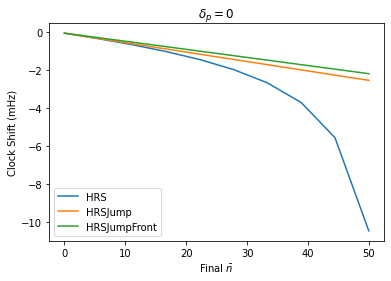

In [12]:
plt.plot(nbarfs, 1e3*HRShifts/(2.*np.pi), label="HRS")
plt.plot(nbarfs, 1e3*HRJumpShifts/(2.*np.pi), label="HRSJump")
plt.plot(nbarfs, 1e3*HRJumpFrontShifts/(2.*np.pi), label="HRSJumpFront")
plt.title(r"$\delta_p = 0$")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.legend()
plt.show()

In [13]:
t1 = 20e-3
T =300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
delPrime = 1. * 2.0*np.pi
Ncut = 300
pts = 10
nbarfs = np.linspace(0, 50, pts)

HRShifts = shiftCurve(HR, t1, T, t2, delPrime, delPrime, Omega0, nbarfs, Ncut)
HRJumpShifts = shiftCurve(HRJump, t1, T, t2, delPrime, delPrime, Omega0, nbarfs, Ncut)
t2 = 20e-3
t1 = 3.*t1
HRJumpFrontShifts = shiftCurve(HRJumpFront, t1, T, t2, delPrime, delPrime, Omega0, nbarfs, Ncut)

0.0019277919610789325
[-1.998072208038921, 2.0019277919610787]
0.1112646982849847
[-1.8887353017150152, 2.1112646982849848]
0.27053318507255086
[-1.729466814927449, 2.270533185072551]
0.48393195881672313
[-1.516068041183277, 2.483931958816723]
0.7595624992979024
[-1.2404375007020976, 2.7595624992979024]
1.1117877080965402
[-0.8882122919034598, 3.11178770809654]
1.562908820601503
[-0.43709117939849707, 3.562908820601503]
2.1399673668549073
[0.1399673668549073, 4.139967366854908]
2.8601674502534196
[0.8601674502534196, 4.860167450253419]
3.700714863593326
[1.7007148635933258, 5.700714863593326]
-0.007863895759225172
[-2.007863895759225, 1.9921361042407748]
-0.017705790228144266
[-2.017705790228144, 1.9822942097718557]
-0.025528718736294538
[-2.0255287187362945, 1.9744712812637055]
-0.031849625475516945
[-2.031849625475517, 1.968150374524483]
-0.03707529179907583
[-2.0370752917990758, 1.9629247082009242]
-0.04152056519792553
[-2.0415205651979256, 1.9584794348020744]
-0.04541706004089944
[

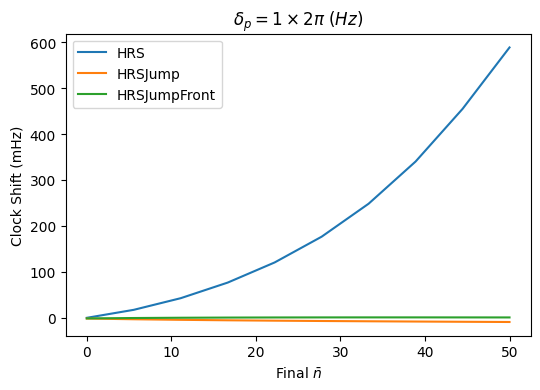

In [14]:
plt.figure(figsize=(6,4), dpi=100)
plt.plot(nbarfs, 1e3*HRShifts/(2.*np.pi), label="HRS")
plt.plot(nbarfs, 1e3*HRJumpShifts/(2.*np.pi), label="HRSJump")
plt.plot(nbarfs, 1e3*HRJumpFrontShifts/(2.*np.pi), label="HRSJumpFront")
plt.title(r"$\delta_p = 1 \times 2\pi \ (Hz)$")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.legend()
plt.show()

## HRS


In [52]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

-0.0025086260991655225
[-2.0025086260991656, 1.9974913739008344]
-0.11544357085743194
[-2.115443570857432, 1.884556429142568]
-0.27860823688173186
[-2.2786082368817318, 1.7213917631182682]
-0.49631514296816814
[-2.496315142968168, 1.503684857031832]
-0.7767428902326878
[-2.776742890232688, 1.2232571097673122]
-1.1342433909732208
[-3.1342433909732206, 0.8657566090267792]
-1.5908857412602566
[-3.590885741260257, 0.4091142587397434]
-2.1729768957128246
[-4.172976895712825, -0.1729768957128246]
-2.896191753027383
[-4.896191753027383, -0.8961917530273831]
-3.7359393490788655
[-5.7359393490788655, -1.7359393490788655]
-0.003630270438839616
[-2.0036302704388396, 1.9963697295611604]
-0.09543401776433706
[-2.095434017764337, 1.9045659822356629]
-0.22872920367551608
[-2.228729203675516, 1.771270796324484]
-0.40832410207970815
[-2.408324102079708, 1.5916758979202918]
-0.6434752264629918
[-2.643475226462992, 1.356524773537008]
-0.9512087382113311
[-2.951208738211331, 1.048791261788669]
-1.36070292

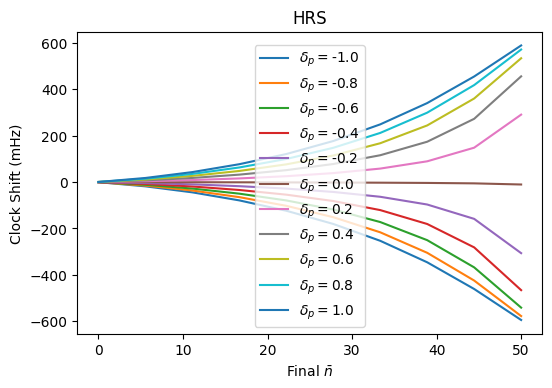

In [53]:
plt.figure(figsize=(6,4), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1) ))
plt.legend()
plt.title("HRS")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

In [54]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
shifts = np.zeros(delPts)

t1 = 20e-3
T = 300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

shifts = shiftCurve(HR, t1, T, t2, 0.0, 0.0, Omega0, nbarfs, Ncut)

-0.0002904172059046688
[-2.0002904172059046, 1.9997095827940954]
-0.0021037649995470286
[-2.0021037649995472, 1.997896235000453]
-0.004091416207724706
[-2.0040914162077246, 1.9959085837922752]
-0.006352027737350965
[-2.0063520277373508, 1.993647972262649]
-0.009023409786444447
[-2.0090234097864443, 1.9909765902135557]
-0.012334225268138831
[-2.012334225268139, 1.9876657747318611]
-0.01673168234431511
[-2.0167316823443153, 1.983268317655685]
-0.023247410484777468
[-2.0232474104847773, 1.9767525895152225]
-0.034898669915694465
[-2.0348986699156946, 1.9651013300843054]
-0.06576822844823757
[-2.0657682284482375, 1.9342317715517625]


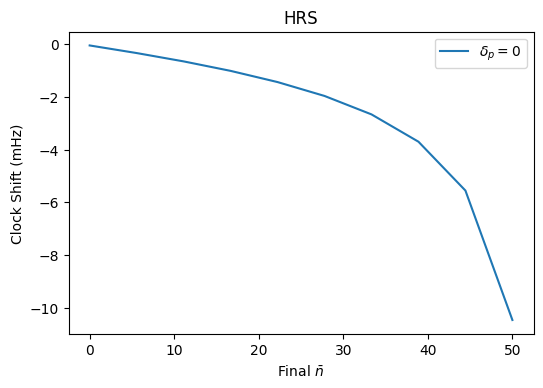

In [56]:
plt.figure(figsize=(6,4), dpi=100)

plt.plot(nbarfs, 1e3*shifts/(2.0*np.pi), label=r"$\delta_p = 0$")
plt.legend()
plt.title("HRS")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

## HRS Jump 

In [9]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJump, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.0072830623276133695
[-1.9927169376723866, 2.0072830623276134]
0.013656558169607992
[-1.986343441830392, 2.013656558169608]
0.01802720437982625
[-1.9819727956201738, 2.0180272043798264]
0.020906329842781412
[-1.9790936701572186, 2.0209063298427816]
0.022696908872133274
[-1.9773030911278666, 2.0226969088721334]
0.02371146401876359
[-1.9762885359812363, 2.0237114640187635]
0.024180301500950387
[-1.9758196984990497, 2.0241803015009503]
0.024263548920176542
[-1.9757364510798234, 2.0242635489201763]
0.024068677421254667
[-1.9759313225787454, 2.024068677421255]
0.02366701753762048
[-1.9763329824623794, 2.0236670175376203]
0.003824313531912369
[-1.9961756864680877, 2.0038243135319123]
0.008274874324317094
[-1.991725125675683, 2.008274874324317]
0.011165555726030126
[-1.9888344442739698, 2.01116555572603]
0.012911154897672479
[-1.9870888451023274, 2.0129111548976724]
0.013828393287589454
[-1.9861716067124104, 2.0138283932875893]
0.0141580426167736
[-1.9858419573832264, 2.014158042616774]
0.01

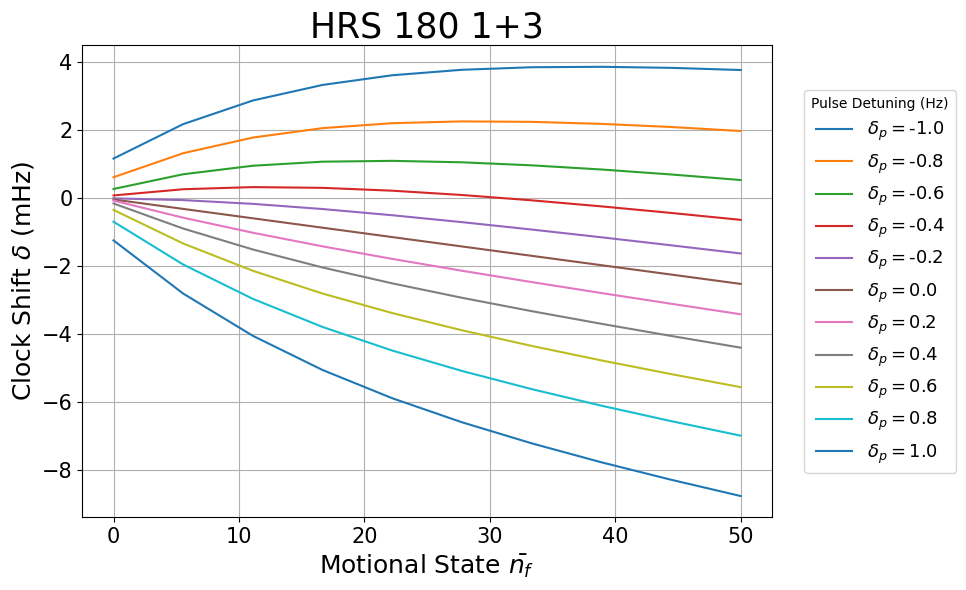

In [10]:
cm=plt.get_cmap('plasma_r',delPts//2+3)


plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 180 1+3",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.set_cmap("viridis") 
plt.show()

In [45]:
delPts = 7
delPrimes = 2.0*np.pi*np.linspace(-0.6, 0.0, delPts)
#delPrimes= np.array([0])
nbarfPts = 25
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
#delPrime = 1. * 2.0*np.pi
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJump, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)


0.0016501936343326484
[-1.9983498063656673, 2.0016501936343327]
0.0028298059333918364
[-1.9971701940666082, 2.0028298059333918]
0.0038149365971332223
[-1.9961850634028668, 2.0038149365971334]
0.004626931420438142
[-1.9953730685795619, 2.004626931420438]
0.0052852156332203635
[-1.9947147843667796, 2.0052852156332204]
0.005807223395883163
[-1.9941927766041168, 2.005807223395883]
0.006208501829196406
[-1.9937914981708036, 2.0062085018291964]
0.006502920156054345
[-1.9934970798439458, 2.0065029201560542]
0.006702911707436398
[-1.9932970882925636, 2.0067029117074364]
0.006819667974038365
[-1.9931803320259616, 2.0068196679740384]
0.006863095093798251
[-1.9931369049062018, 2.0068630950937982]
0.006842547974658554
[-1.9931574520253414, 2.0068425479746588]
0.006766022651463762
[-1.9932339773485361, 2.0067660226514636]
0.006640281934120073
[-1.99335971806588, 2.00664028193412]
0.006471667492534296
[-1.9935283325074658, 2.0064716674925345]
0.006265553061697929
[-1.993734446938302, 2.0062655530616

-0.002794591473926625
[-2.0027945914739265, 1.9972054085260733]
-0.0032988828996892896
[-2.0032988828996894, 1.9967011171003106]
-0.0038178504996087327
[-2.0038178504996087, 1.9961821495003913]
-0.004349722772037269
[-2.0043497227720373, 1.9956502772279627]
-0.004892915369305944
[-2.004892915369306, 1.995107084630694]
-0.0054460159132859835
[-2.005446015913286, 1.994553984086714]
-0.006007773046831602
[-2.0060077730468318, 1.9939922269531685]
-0.006577086114612538
[-2.0065770861146124, 1.9934229138853874]
-0.007152993911314945
[-2.007152993911315, 1.9928470060886851]
-0.007734662305622463
[-2.0077346623056225, 1.9922653376943775]
-0.008321371187060085
[-2.0083213711870602, 1.99167862881294]
-0.00891250134465736
[-2.0089125013446574, 1.9910874986553426]
-0.009507521812866102
[-2.009507521812866, 1.9904924781871338]
-0.010105978066010853
[-2.0101059780660107, 1.9898940219339891]
-0.01070748128543917
[-2.010707481285439, 1.989292518714561]
-0.011311698795647588
[-2.0113116987956476, 1.988

In [50]:
delPrime = -2.0*np.pi*0.352
nbarfPts = 25
nbarfs = np.linspace(0, 50, nbarfPts)

t1 = 20e-3
T = 300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

optResult = shiftCurve(HRJump, t1, T, t2, delPrime, delPrime, Omega0, nbarfs, Ncut)

0.0002768059878596321
[-1.9997231940121403, 2.0002768059878595]
0.0006634401795343695
[-1.9993365598204655, 2.0006634401795345]
0.0009374747136514569
[-1.9990625252863485, 2.0009374747136515]
0.0011118060751589456
[-1.998888193924841, 2.001111806075159]
0.0011980393120933884
[-1.9988019606879066, 2.001198039312093]
0.0012065580996647534
[-1.9987934419003353, 2.001206558099665]
0.0011463254907245516
[-1.9988536745092755, 2.0011463254907245]
0.0010255027636143276
[-1.9989744972363857, 2.001025502763614]
0.000851318502634867
[-1.9991486814973651, 2.000851318502635]
0.0006301645638122031
[-1.9993698354361877, 2.000630164563812]
0.00036779458535826165
[-1.9996322054146418, 2.000367794585358]
6.933979328820541e-05
[-1.9999306602067117, 2.000069339793288]
-0.00026065316623052345
[-2.0002606531662304, 1.9997393468337694]
-0.0006181856399448242
[-2.000618185639945, 1.9993818143600552]
-0.0009997663553533624
[-2.000999766355353, 1.9990002336446466]
-0.0014023663813810966
[-2.001402366381381, 1.9

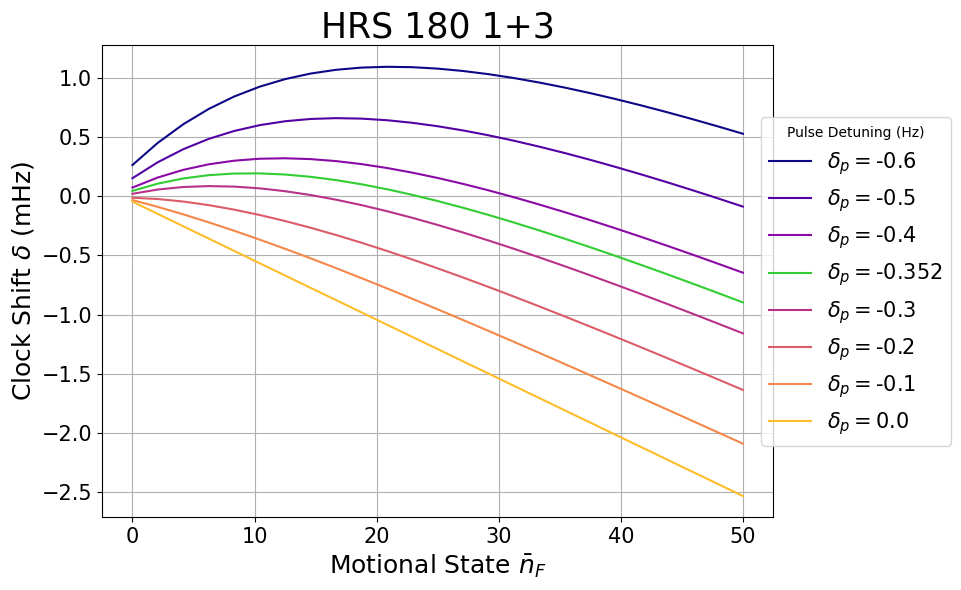

2.5330539491581576

In [54]:
cm=plt.get_cmap('plasma',delPts+1)


plt.figure(figsize=(10,6), dpi=100)
for ii in range(3):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)), color=cm(ii))

plt.plot(nbarfs, 1e3*optResult/(2.0*np.pi), label=r"$\delta_p = $" + str(-0.352), color='limegreen')

for ii in range(3,7):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)), color=cm(ii))
plt.title("HRS 180 1+3",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n}_F$",fontsize="18")
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="15", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.set_cmap("viridis") 
plt.grid()
plt.show()

np.max(np.abs(1e3*results/(2.*np.pi)))

In [52]:
for ii in range(2,4):
    print(ii)

2
3


## HRS Jump Front

In [15]:
delPts = 7
delPrimes = 2.0*np.pi*np.linspace(0.0, 0.6, delPts)
nbarfPts = 25
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t2 = 20e-3
T = 300e-3
t1 = 3.*t2
Omega0 = np.pi/(2.*t2)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJumpFront, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

-0.0002904172059046669
[-2.0002904172059046, 1.9997095827940954]
-0.0008447776815802046
[-2.0008447776815803, 1.9991552223184197]
-0.0014001428628703846
[-2.0014001428628703, 1.9985998571371295]
-0.0019563407951201615
[-2.00195634079512, 1.9980436592048798]
-0.0025132337325405197
[-2.0025132337325404, 1.9974867662674596]
-0.00307070618247718
[-2.003070706182477, 1.9969292938175227]
-0.003628661501305531
[-2.0036286615013057, 1.9963713384986945]
-0.0041870190567598236
[-2.0041870190567597, 1.9958129809432401]
-0.004745711972029691
[-2.0047457119720296, 1.9952542880279702]
-0.005304685273374882
[-2.0053046852733747, 1.994695314726625]
-0.005863894241092169
[-2.005863894241092, 1.9941361057589078]
-0.006423302863225617
[-2.0064233028632255, 1.9935766971367743]
-0.006982882383420651
[-2.006982882383421, 1.9930171176165794]
-0.007542609973766563
[-2.0075426099737665, 1.9924573900262335]
-0.008102467563295726
[-2.0081024675632957, 1.9918975324367043]
-0.008662440837570005
[-2.00866244083757,

0.0022975362948770882
[-1.9977024637051228, 2.002297536294877]
0.0025595822563608695
[-1.9974404177436391, 2.0025595822563607]
0.0027360679307519755
[-1.997263932069248, 2.0027360679307518]
0.0028373009396727815
[-1.9971626990603273, 2.0028373009396727]
0.0028722280464039615
[-1.997127771953596, 2.002872228046404]
0.002849541852913319
[-1.9971504581470867, 2.0028495418529135]
0.002776340711592561
[-1.9972236592884074, 2.0027763407115926]
0.002658751622867094
[-1.997341248377133, 2.002658751622867]
0.002502577447189658
[-1.9974974225528104, 2.00250257744719]
0.002312722802583908
[-1.9976872771974161, 2.002312722802584]
0.0020934353980109053
[-1.9979065646019891, 2.002093435398011]
0.0018483762882287606
[-1.9981516237117711, 2.001848376288229]
0.0015806894763328101
[-1.9984193105236672, 2.0015806894763326]
0.0012930683210932853
[-1.9987069316789068, 2.001293068321093]
0.0009878169859832114
[-1.9990121830140168, 2.000987816985983]
0.0006669059437222364
[-1.9993330940562777, 2.000666905943

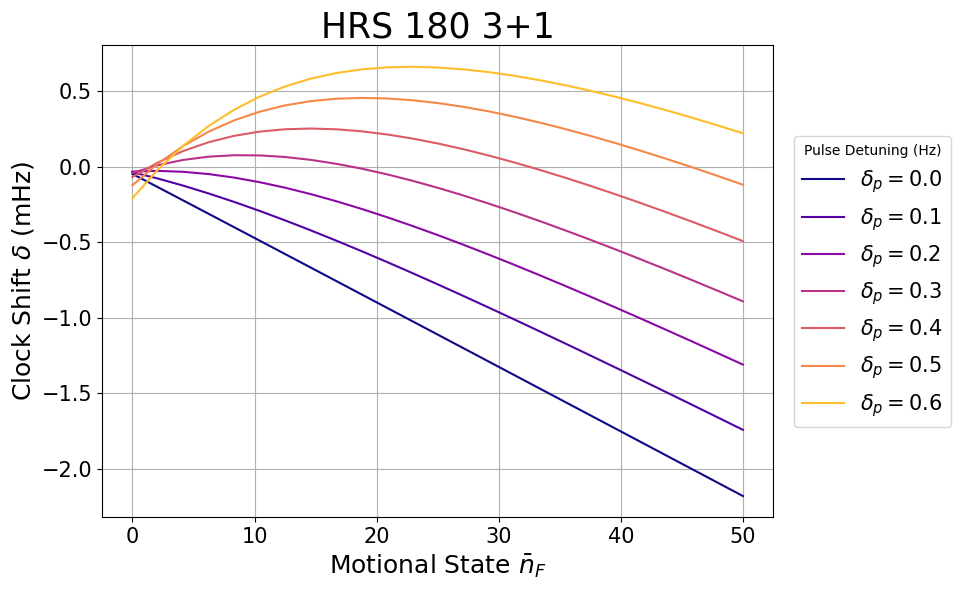

In [16]:
cm=plt.get_cmap('plasma',delPts+1)


plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)), color=cm(ii))
plt.title("HRS 180 3+1",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n}_F$",fontsize="18")
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="15", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.set_cmap("viridis") 
plt.grid()
plt.show()

In [21]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(0., 0.6, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t2 = 20e-3
T = 300e-3
t1 = 3.*t2
Omega0 = np.pi/(2.*t2)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJumpFront, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

-0.0002904172059046669
[-2.0002904172059046, 1.9997095827940954]
-0.0017708579523384423
[-2.0017708579523386, 1.9982291420476617]
-0.003256641924037382
[-2.0032566419240374, 1.9967433580759626]
-0.00474571197202336
[-2.0047457119720233, 1.9952542880279767]
-0.006236813047885752
[-2.006236813047886, 1.9937631869521142]
-0.007729215501416982
[-2.007729215501417, 1.992270784498583]
-0.009222518408243082
[-2.0092225184082433, 1.990777481591757]
-0.01071650428150985
[-2.01071650428151, 1.9892834957184902]
-0.012211048535707123
[-2.012211048535707, 1.9877889514642928]
-0.013706070836696727
[-2.0137060708366965, 1.9862939291633033]
-0.0002466036583489218
[-2.000246603658349, 1.9997533963416512]
-0.0013033982074013135
[-2.0013033982074013, 1.9986966017925987]
-0.002477531983744985
[-2.002477531983745, 1.997522468016255]
-0.003734746035820135
[-2.00373474603582, 1.9962652539641799]
-0.00505059699441193
[-2.005050596994412, 1.994949403005588]
-0.0064074409371887965
[-2.006407440937189, 1.9935925

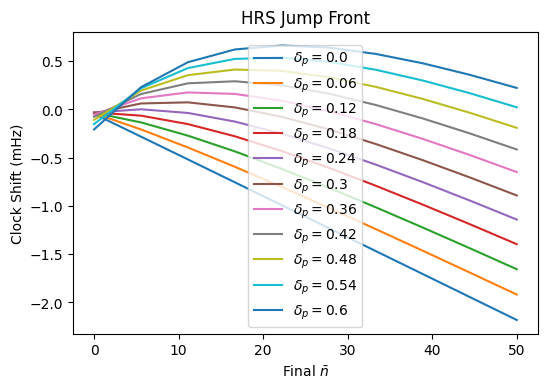

In [22]:
plt.figure(figsize=(6,4), dpi=100)

for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 3) ))
plt.legend()
plt.title("HRS Jump Front")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

## MHRS

In [23]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-5,0, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t = 20e-3
T = 300e-3
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    #MHR1(deld, psi0, t, T, delPrime, Omega0, nbarf, Ncut)
    results[ii,:] = shiftCurve2(MHR1, t, T, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.003949695912563305
[-1.9960503040874367, 2.003949695912563]
0.04193816720780502
[-1.958061832792195, 2.041938167207805]
0.07170640497048264
[-1.9282935950295172, 2.0717064049704828]
0.09526547396757569
[-1.9047345260324242, 2.095265473967576]
0.11407336736013705
[-1.885926632639863, 2.114073367360137]
0.12931559122377592
[-1.870684408776224, 2.129315591223776]
0.1419418760225907
[-1.8580581239774092, 2.1419418760225906]
0.15265696676976448
[-1.8473430332302354, 2.1526569667697646]
0.1619542217962399
[-1.83804577820376, 2.1619542217962398]
0.1701695313576577
[-1.8298304686423423, 2.170169531357658]
0.0022401589623988337
[-1.9977598410376012, 2.002240158962399]
0.022858954565495315
[-1.9771410454345046, 2.0228589545654954]
0.03799900945849153
[-1.9620009905415086, 2.0379990094584914]
0.049423978632475676
[-1.9505760213675243, 2.0494239786324755]
0.05824299544257006
[-1.94175700455743, 2.05824299544257]
0.06521828103307159
[-1.9347817189669283, 2.0652182810330717]
0.07089036526114867
[-

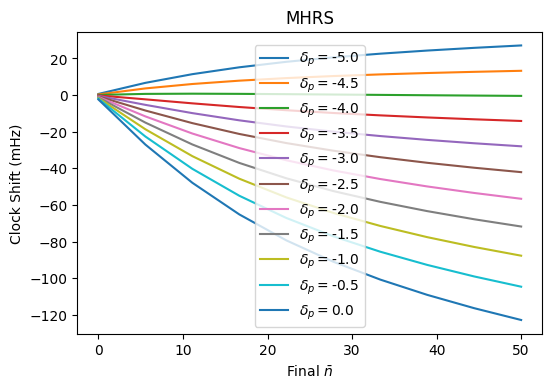

In [24]:
plt.figure(figsize=(6,4), dpi=100)

for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1) ))
plt.legend()
plt.title("MHRS")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

In [25]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-3.9,-4.1, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t = 20e-3
T = 300e-3
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    #MHR1(deld, psi0, t, T, delPrime, Omega0, nbarf, Ncut)
    results[ii,:] = shiftCurve2(MHR1, t, T, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.00022944656094231008
[-1.9997705534390577, 2.0002294465609425]
0.00035943643891988696
[-1.99964056356108, 2.0003594364389197]
-0.0018213382607689293
[-2.001821338260769, 1.998178661739231]
-0.004802302139303778
[-2.004802302139304, 1.9951976978606962]
-0.007865008186707266
[-2.007865008186707, 1.9921349918132927]
-0.010737092636598743
[-2.0107370926365986, 1.9892629073634012]
-0.013357586465600908
[-2.013357586465601, 1.9866424135343992]
-0.015741501377990654
[-2.0157415013779905, 1.9842584986220093]
-0.017920805523610202
[-2.01792080552361, 1.9820791944763898]
-0.019924847820251935
[-2.019924847820252, 1.9800751521797482]
0.00029619424271845764
[-1.9997038057572816, 2.0002961942427184]
0.001106907399804158
[-1.9988930926001958, 2.0011069073998042]
-0.0004976593403064392
[-2.0004976593403065, 1.9995023406596935]
-0.002999014718430042
[-2.00299901471843, 1.99700098528157]
-0.005665957450066549
[-2.0056659574500664, 1.9943340425499334]
-0.0082099359507548
[-2.0082099359507546, 1.991790

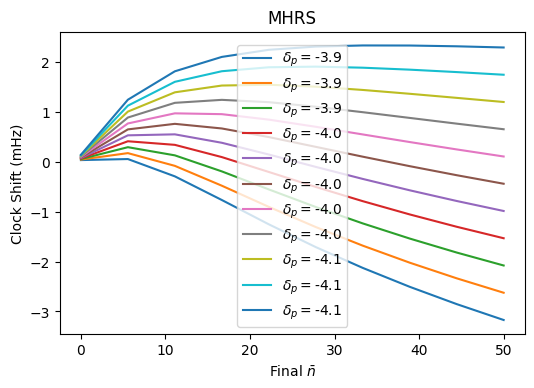

In [26]:
plt.figure(figsize=(6,4), dpi=100)

for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1) ))
plt.legend()
plt.title("MHRS")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

# Only Detune Second Pulse
## HR Jump

In [27]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJump, t1, T, t2, 0.0, delPrimes[ii], Omega0, nbarfs, Ncut)

-0.25930209257156767
[-2.2593020925715677, 1.7406979074284323]
-0.252928397078921
[-2.252928397078921, 1.7470716029210789]
-0.24855775086870147
[-2.2485577508687014, 1.7514422491312986]
-0.24567862540574648
[-2.2456786254057466, 1.7543213745942534]
-0.2438880463763939
[-2.243888046376394, 1.756111953623606]
-0.24287349122976493
[-2.2428734912297648, 1.757126508770235]
-0.24240465374757647
[-2.2424046537475766, 1.7575953462524234]
-0.2423214063283503
[-2.24232140632835, 1.7576785936716497]
-0.24251627782727408
[-2.2425162778272743, 1.757483722172726]
-0.2429179377109056
[-2.2429179377109056, 1.7570820622890944]
-0.20946727185703737
[-2.2094672718570374, 1.7905327281429626]
-0.2050166047260973
[-2.2050166047260973, 1.7949833952739027]
-0.20212592332438328
[-2.2021259233243833, 1.7978740766756167]
-0.2003803241527424
[-2.2003803241527424, 1.7996196758472576]
-0.1994630857628241
[-2.199463085762824, 1.8005369142371759]
-0.1991334364336403
[-2.19913343643364, 1.8008665635663597]
-0.19921582

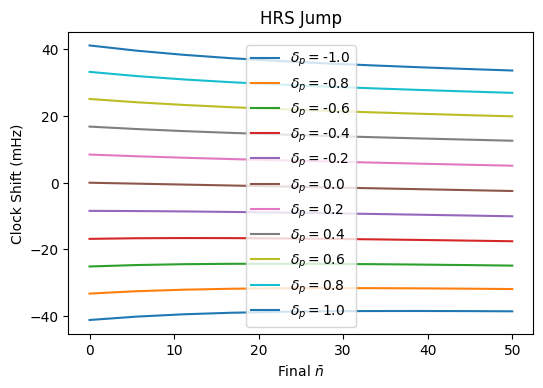

In [28]:
plt.figure(figsize=(6,4), dpi=100)

for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 3) ))
plt.legend()
plt.title("HRS Jump")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

# Only Detune First Pulse
## HRS Jump

In [29]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJump, t1, T, t2, delPrimes[ii], 0.0, Omega0, nbarfs, Ncut)

0.26629454623455356
[-1.7337054537654464, 2.2662945462345534]
0.2645482283525628
[-1.7354517716474371, 2.2645482283525626]
0.26280724551135143
[-1.7371927544886485, 2.2628072455113513]
0.261069548763648
[-1.738930451236352, 2.261069548763648]
0.25933388307199445
[-1.7406661169280055, 2.2593338830719945]
0.25759951879769427
[-1.7424004812023057, 2.2575995187976945]
0.25586605502817694
[-1.7441339449718232, 2.255866055028177]
0.2541332742887272
[-1.7458667257112728, 2.2541332742887272]
0.25240105200786755
[-1.7475989479921323, 2.2524010520078677]
0.25066930789289527
[-1.7493306921071048, 2.2506693078928954]
0.21300107003643534
[-1.7869989299635647, 2.2130010700364355]
0.2112547521544499
[-1.7887452478455501, 2.21125475215445]
0.2095137693132397
[-1.7904862306867604, 2.2095137693132396]
0.20777607256553193
[-1.792223927434468, 2.2077760725655318]
0.20604040687388292
[-1.7939595931261172, 2.206040406873883]
0.20430604259957755
[-1.7956939574004225, 2.2043060425995775]
0.20257257883006144
[

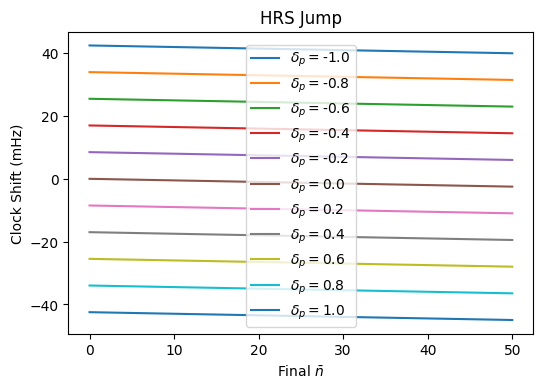

In [30]:
plt.figure(figsize=(6,4), dpi=100)

for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 3) ))
plt.legend()
plt.title("HRS Jump")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

# Ncut Convergence Test

In [10]:
Ncuts = np.array([10, 50, 100, 200, 300, 400, 500, 700, 900])
NcutPts = np.size(Ncuts)

nbarfPts = 25
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([NcutPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
delPrime = -0.4*2.*np.pi

for ii in range(NcutPts):
    results[ii,:] = shiftCurve(HRJump, t1, T, t2, delPrime, delPrime, Omega0, nbarfs, Ncuts[ii])

0.0004537205210427994
[-1.9995462794789571, 2.0004537205210426]
0.0008871391584290357
[-1.999112860841571, 2.000887139158429]
0.0007717951764059851
[-1.999228204823594, 2.000771795176406]
0.00037575287494055726
[-1.9996242471250594, 2.0003757528749406]
-0.00013259952454029465
[-2.0001325995245405, 1.9998674004754597]
-0.0006940489891264468
[-2.0006940489891263, 1.9993059510108735]
-0.0012843333990092938
[-2.0012843333990094, 1.9987156666009906]
-0.0018919122851432661
[-2.001891912285143, 1.9981080877148567]
-0.002510645965953462
[-2.0025106459659536, 1.9974893540340466]
-0.0031369813397251417
[-2.003136981339725, 1.996863018660275]
-0.003768724371462896
[-2.003768724371463, 1.9962312756285372]
-0.004404448869833522
[-2.0044044488698334, 1.9955955511301664]
-0.005043188414980808
[-2.0050431884149806, 1.9949568115850191]
-0.005684265279070634
[-2.0056842652790707, 1.9943157347209293]
-0.006327190307401944
[-2.006327190307402, 1.993672809692598]
-0.006971601697523026
[-2.006971601697523, 

0.0019836901100577314
[-1.9980163098899422, 2.0019836901100576]
0.002008976636313085
[-1.9979910233636868, 2.002008976636313]
0.001964798533631903
[-1.998035201466368, 2.0019647985336317]
0.0018594486356731037
[-1.9981405513643269, 2.001859448635673]
0.0017005417800827086
[-1.9982994582199174, 2.0017005417800826]
0.0014944898650654705
[-1.9985055101349345, 2.0014944898650655]
0.0012471604749493925
[-1.9987528395250507, 2.0012471604749495]
0.0009637623311944696
[-1.9990362376688056, 2.0009637623311947]
0.0006488879826877056
[-1.9993511120173122, 2.000648887982688]
0.00030656045515681897
[-1.9996934395448431, 2.0003065604551566]
-5.971605683946547e-05
[-2.0000597160568394, 1.9999402839431606]
-0.00044690352498335205
[-2.0004469035249834, 1.9995530964750166]
-0.0008523778378938133
[-2.000852377837894, 1.9991476221621063]
-0.0012738788826750444
[-2.001273878882675, 1.998726121117325]
-0.0017094642062946595
[-2.0017094642062947, 1.9982905357937053]
-0.0021574669124000017
[-2.0021574669124, 

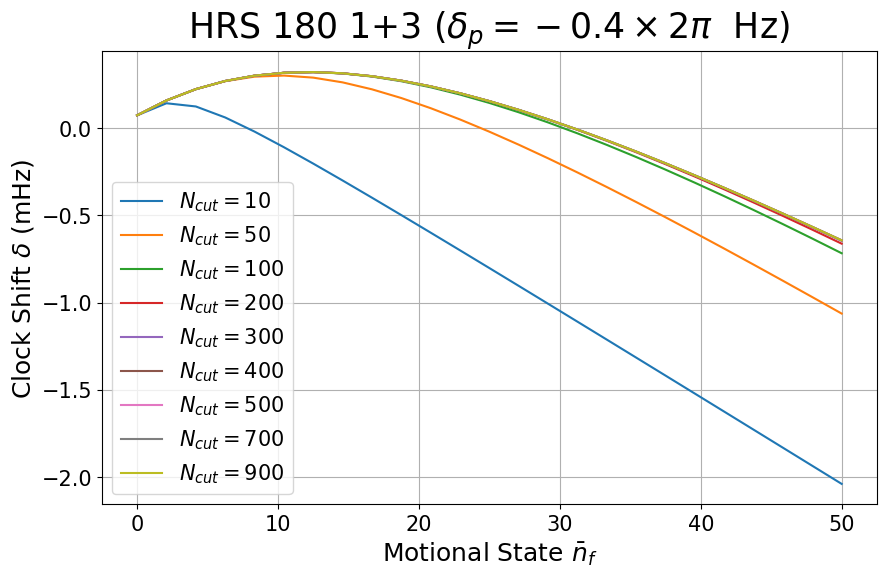

In [14]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(NcutPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$N_{cut} = $" + str(Ncuts[ii]) )
plt.legend(fontsize="15")
plt.title(r"HRS 180 1+3 ($\delta_p = -0.4 \times 2\pi \ $ Hz)",fontsize="25")
plt.ylabel("Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n}_f$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.show()


In [18]:
maxErr=0
for ii in range(nbarfPts):
    err = np.abs((results[4,ii]-results[8,ii])/results[8,ii])
    if err > maxErr: maxErr=err
print(maxErr*100)

1.0049650834551611


# Optimization
Utilizing offset detunings during the two pulses

In [33]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
delpOff = 0.1*2.*np.pi
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t2 = 20e-3
T = 300e-3
t1 = 3.*t2
Omega0 = np.pi/(2.*t2)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJumpFront, t1, T, t2, delPrimes[ii], delPrimes[ii]+delpOff, Omega0, nbarfs, Ncut)

-0.02089305889737205
[-2.020893058897372, 1.9791069411026279]
-0.028717861796288435
[-2.0287178617962884, 1.9712821382037116]
-0.034871429800010324
[-2.03487142980001, 1.9651285701999897]
-0.03983350037026102
[-2.039833500370261, 1.960166499629739]
-0.04394988702643942
[-2.0439498870264394, 1.9560501129735606]
-0.047473098617686234
[-2.047473098617686, 1.9525269013823137]
-0.05058301623176907
[-2.050583016231769, 1.949416983768231]
-0.0534025482948061
[-2.053402548294806, 1.9465974517051938]
-0.05601345892494927
[-2.0560134589249492, 1.9439865410750508]
-0.05846977053561049
[-2.0584697705356105, 1.9415302294643895]
-0.024011052586068758
[-2.0240110525860686, 1.9759889474139312]
-0.030429205947097943
[-2.030429205947098, 1.9695707940529021]
-0.035547646921368366
[-2.0355476469213682, 1.9644523530786315]
-0.0397394391980844
[-2.0397394391980845, 1.9602605608019157]
-0.04327350401986115
[-2.043273504019861, 1.956726495980139]
-0.046346222133118856
[-2.046346222133119, 1.9536537778668812]


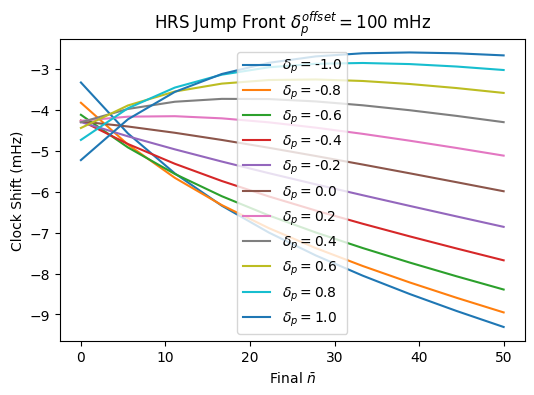

In [34]:
plt.figure(figsize=(6,4), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p= $" + str(round(delPrimes[ii]/(2.0*np.pi), 1) ))
plt.legend()
plt.title(r"HRS Jump Front $\delta_p^{offset} = 100$ mHz")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

That was too much of an offset, now I'll dial it in:

In [35]:
delPts = 5
delPrimes = 2.0*np.pi*np.linspace(0.8,1.2, delPts)
delpOff = 0.03*2.*np.pi
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t2 = 20e-3
T = 300e-3
t1 = 3.*t2
Omega0 = np.pi/(2.*t2)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJumpFront, t1, T, t2, delPrimes[ii], delPrimes[ii]+delpOff, Omega0, nbarfs, Ncut)

-0.011119786849339966
[-2.01111978684934, 1.98888021315066]
-0.006748232045383041
[-2.006748232045383, 1.993251767954617]
-0.003928411678151144
[-2.0039284116781513, 1.996071588321849]
-0.0022140065257171392
[-2.0022140065257172, 1.9977859934742828]
-0.001283592055691907
[-2.001283592055692, 1.998716407944308]
-0.0009028355522187968
[-2.000902835552219, 1.9990971644477813]
-0.0009052658309306876
[-2.0009052658309305, 1.9990947341690692]
-0.0011764026538071477
[-2.0011764026538073, 1.9988235973461927]
-0.0016412736900625372
[-2.0016412736900624, 1.9983587263099374]
-0.0022496642246595242
[-2.0022496642246597, 1.9977503357753406]
-0.012496822799030768
[-2.0124968227990307, 1.9875031772009693]
-0.00742251001689081
[-2.007422510016891, 1.9925774899831092]
-0.004085532533462663
[-2.0040855325334626, 1.9959144674665374]
-0.0019862726522126757
[-2.001986272652213, 1.9980137273477874]
-0.0007649035447256186
[-2.0007649035447255, 1.9992350964552743]
-0.0001590557200951438
[-2.0001590557200952, 

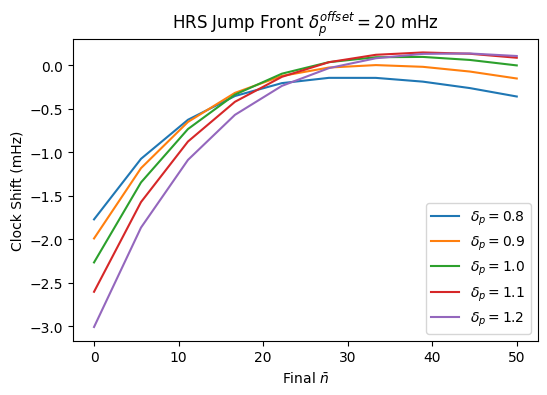

In [36]:
plt.figure(figsize=(6,4), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p= $" + str(round(delPrimes[ii]/(2.0*np.pi), 1) ))
plt.legend()
plt.title(r"HRS Jump Front $\delta_p^{offset} = 20$ mHz")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

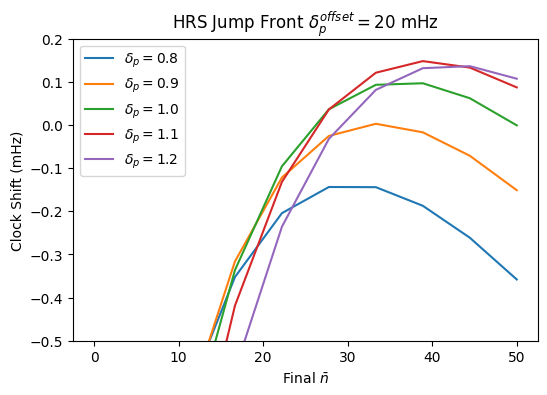

In [37]:
plt.figure(figsize=(6,4), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p= $" + str(round(delPrimes[ii]/(2.0*np.pi), 1) ))
plt.legend()
plt.title(r"HRS Jump Front $\delta_p^{offset} = 20$ mHz")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.ylim([-0.5,0.2])
plt.show()

Now to try this with the HRS Jump sequence

In [38]:
delPts = 5
delPrimes = 2.0*np.pi*np.linspace(-1.2,-0.8, delPts)
delpOff = -0.12*2.*np.pi
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJump, t1, T, t2, delPrimes[ii], delPrimes[ii]+delpOff, Omega0, nbarfs, Ncut)

-0.01574306870658419
[-2.015743068706584, 1.9842569312934157]
-0.005779380348909836
[-2.0057793803489097, 1.99422061965109]
0.0013964620339637088
[-1.9986035379660363, 2.0013964620339637]
0.006442268593760096
[-1.9935577314062398, 2.00644226859376]
0.00990998666479238
[-1.9900900133352075, 2.0099099866647925]
0.012243466593737058
[-1.987756533406263, 2.012243466593737]
0.013775786568985631
[-1.9862242134310144, 2.013775786568986]
0.014740531772632619
[-1.9852594682273674, 2.014740531772633]
0.0152951223688351
[-1.9847048776311649, 2.015295122368835]
0.015544254651291837
[-1.9844557453487082, 2.015544254651292]
-0.019041680466108768
[-2.019041680466109, 1.9809583195338911]
-0.010275175178849865
[-2.0102751751788497, 1.98972482482115]
-0.00403984953688511
[-2.004039849536885, 1.9959601504631148]
0.0002775057354502757
[-1.9997224942645497, 2.0002775057354505]
0.0031805623319882295
[-1.9968194376680117, 2.003180562331988]
0.005069646764899525
[-1.9949303532351004, 2.0050696467648996]
0.006

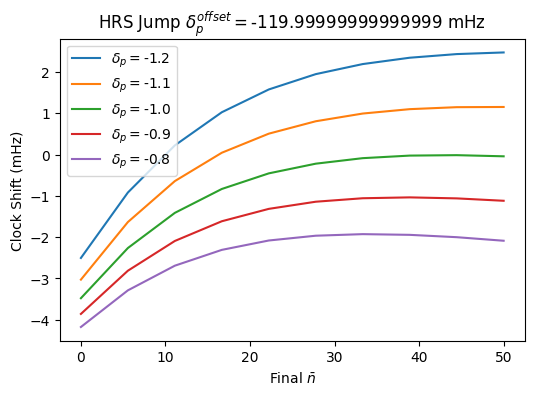

In [39]:
plt.figure(figsize=(6,4), dpi=100)

for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 3) ))
plt.legend()
plt.title(r"HRS Jump $\delta_p^{offset} =$"+str(delpOff*1000./(2.*np.pi))+" mHz")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

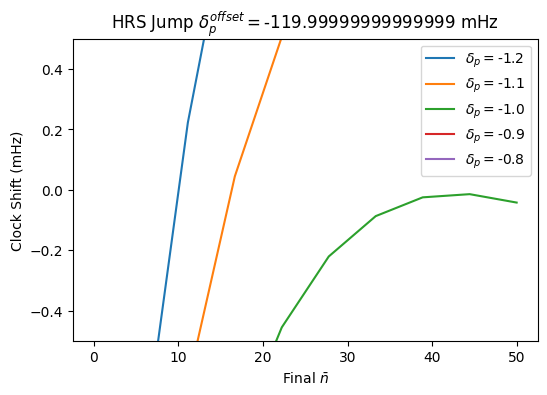

In [40]:
plt.figure(figsize=(6,4), dpi=100)

for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 3) ))
plt.legend()
plt.title(r"HRS Jump $\delta_p^{offset} =$"+str(delpOff*1000./(2.*np.pi))+" mHz")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.ylim([-0.5,0.5])
plt.show()


# Testing Effect of Different Dark Times

In [41]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t2 = 20e-3
T = 100e-3
t1 = 3.*t2
Omega0 = np.pi/(2.*t2)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJumpFront, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.01761014007134014
[-1.9823898599286598, 2.01761014007134]
-0.004744133246309582
[-2.0047441332463096, 1.9952558667536904]
-0.021528506651563264
[-2.0215285066515634, 1.9784714933484366]
-0.03434180210732538
[-2.0343418021073254, 1.9656581978926746]
-0.04433655432046149
[-2.0443365543204615, 1.9556634456795385]
-0.052354328459446285
[-2.052354328459446, 1.9476456715405537]
-0.05899462329895831
[-2.0589946232989584, 1.9410053767010418]
-0.06466705513108892
[-2.064667055131089, 1.9353329448689112]
-0.06964406059321238
[-2.0696440605932125, 1.9303559394067875]
-0.07410574777882098
[-2.074105747778821, 1.925894252221179]
0.008280620624968201
[-1.9917193793750319, 2.0082806206249684]
-0.009858080516806351
[-2.0098580805168065, 1.9901419194831937]
-0.02354002105854399
[-2.023540021058544, 1.976459978941456]
-0.034044530764394
[-2.034044530764394, 1.965955469235606]
-0.04229378698329946
[-2.0422937869832993, 1.9577062130167004]
-0.04896117137610777
[-2.048961171376108, 1.9510388286238922]
-0

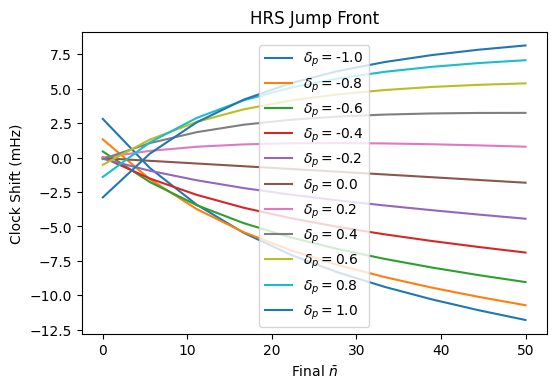

In [42]:
plt.figure(figsize=(6,4), dpi=100)

for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1) ))
plt.legend()
plt.title("HRS Jump Front")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

In [43]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t2 = 20e-3
T = 500e-3
t1 = 3.*t2
Omega0 = np.pi/(2.*t2)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJumpFront, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.003289699665765017
[-1.996710300334235, 2.003289699665765]
-0.0024718605334922675
[-2.0024718605334924, 1.9975281394665076]
-0.007119441969500897
[-2.007119441969501, 1.9928805580304991]
-0.010972807801803786
[-2.010972807801804, 1.9890271921981961]
-0.014262464979324839
[-2.014262464979325, 1.9857375350206752]
-0.017156726539032482
[-2.0171567265390324, 1.9828432734609676]
-0.01977549223737666
[-2.0197754922373767, 1.9802245077626233]
-0.02220068533347365
[-2.0222006853334737, 1.9777993146665263]
-0.024486804469415407
[-2.0244868044694155, 1.9755131955305847]
-0.026669857762558535
[-2.0266698577625584, 1.9733301422374414]
0.001423607102072304
[-1.9985763928979277, 2.001423607102072]
-0.0034946500085484772
[-2.0034946500085486, 1.9965053499914516]
-0.007521744861082808
[-2.0075217448610827, 1.9924782551389173]
-0.010913353538508188
[-2.010913353538508, 1.9890866464614918]
-0.013853911514851153
[-2.0138539115148513, 1.986146088485149]
-0.01647809512416181
[-2.0164780951241617, 1.98352

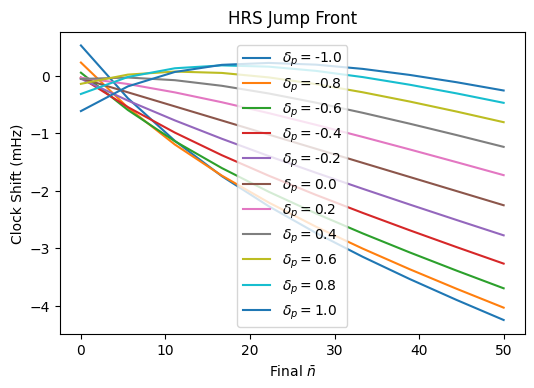

In [44]:
plt.figure(figsize=(6,4), dpi=100)

for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1) ))
plt.legend()
plt.title("HRS Jump Front")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

# Testing Effect of Different Rabi Rates
(Keeping T_ramsey=500 ms)

In [45]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(0,5, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t2 = 5e-3
T = 500e-3
t1 = 3.*t2
Omega0 = np.pi/(2.*t2)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJumpFront, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

-0.00029047269004290997
[-2.000290472690043, 1.999709527309957]
-0.0018838522526668457
[-2.001883852252667, 1.9981161477473333]
-0.0034780957475631317
[-2.003478095747563, 1.996521904252437]
-0.00507283215389096
[-2.005072832153891, 1.9949271678461091]
-0.006667873214391112
[-2.006667873214391, 1.9933321267856088]
-0.00826310948152638
[-2.0082631094815264, 1.9917368905184736]
-0.009858480816638945
[-2.009858480816639, 1.9901415191833611]
-0.011453954596682588
[-2.0114539545966825, 1.9885460454033175]
-0.013049512133119136
[-2.013049512133119, 1.9869504878668809]
-0.014645141363570839
[-2.014645141363571, 1.9853548586364291]
-0.00024185302589129214
[-2.000241853025891, 1.9997581469741088]
-0.001305696729567193
[-2.0013056967295673, 1.9986943032704327]
-0.002510386082279154
[-2.002510386082279, 1.997489613917721]
-0.003815308466610919
[-2.003815308466611, 1.9961846915333892]
-0.005191291157178766
[-2.0051912911571788, 1.9948087088428212]
-0.006617082453833657
[-2.006617082453834, 1.99338

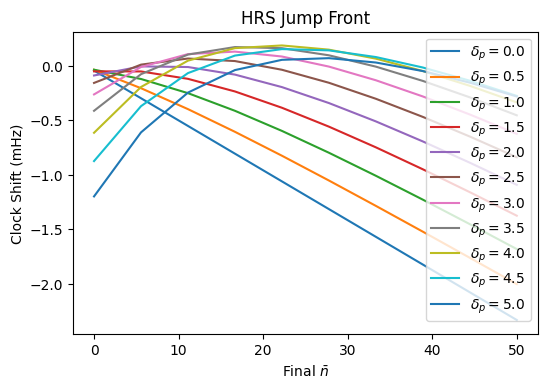

In [46]:
plt.figure(figsize=(6,4), dpi=100)

for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1) ))
plt.legend()
plt.title("HRS Jump Front")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

In [47]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t2 = 40e-3
T = 500e-3
t1 = 3.*t2
Omega0 = np.pi/(2.*t2)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJumpFront, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.029667112511765188
[-1.9703328874882349, 2.029667112511765]
0.019808450965874903
[-1.980191549034125, 2.0198084509658747]
0.012161063806141362
[-1.9878389361938587, 2.0121610638061416]
0.006091614740000491
[-1.9939083852599995, 2.0060916147400003]
0.0011428121483460585
[-1.998857187851654, 2.001142812148346]
-0.0030196271364135874
[-2.0030196271364136, 1.9969803728635864]
-0.006634007683597572
[-2.006634007683598, 1.9933659923164024]
-0.009863228963417842
[-2.0098632289634177, 1.9901367710365823]
-0.012815689577435839
[-2.012815689577436, 1.9871843104225642]
-0.015563023580175165
[-2.0155630235801754, 1.9844369764198249]
0.015118949021332392
[-1.9848810509786676, 2.0151189490213324]
0.006921625137929461
[-1.9930783748620706, 2.0069216251379296]
0.0004984439708643346
[-1.9995015560291356, 2.0004984439708644]
-0.004659147720701251
[-2.004659147720701, 1.9953408522792988]
-0.00891811092870301
[-2.008918110928703, 1.991081889071297]
-0.012546596351619085
[-2.012546596351619, 1.9874534036

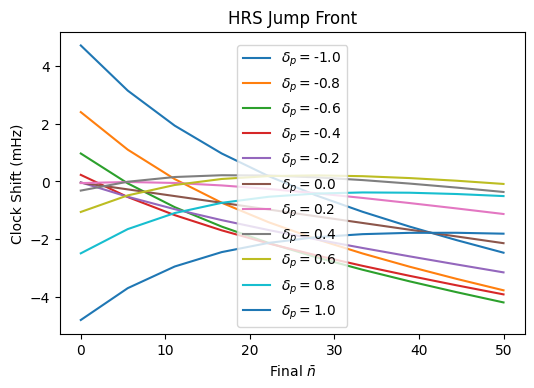

In [48]:
plt.figure(figsize=(6,4), dpi=100)

for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1) ))
plt.legend()
plt.title("HRS Jump Front")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

# Attempt 1 at Final Plots

In [49]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(0.3,0.5, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t2 = 40e-3
T = 500e-3
t1 = 3.*t2
Omega0 = np.pi/(2.*t2)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJumpFront, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

-0.000898777212275798
[-2.0008987772122757, 1.9991012227877243]
0.00018755241475906768
[-1.999812447585241, 2.000187552414759]
0.0005959165631813835
[-1.9994040834368185, 2.0005959165631815]
0.0005219581738132813
[-1.9994780418261868, 2.000521958173813]
0.00010617535239353024
[-1.9998938246476066, 2.0001061753523937]
-0.0005491569325726625
[-2.0005491569325726, 1.9994508430674274]
-0.0013713781629308712
[-2.001371378162931, 1.998628621837069]
-0.0023109346738295834
[-2.0023109346738295, 1.9976890653261705]
-0.0033348946900776766
[-2.0033348946900777, 1.9966651053099223]
-0.004421503610522117
[-2.004421503610522, 1.9955784963894778]
-0.001067834128658919
[-2.001067834128659, 1.998932165871341]
0.0001875880758271372
[-1.999812411924173, 2.000187588075827]
0.0007203407306257423
[-1.9992796592693742, 2.0007203407306258]
0.0007389356510914395
[-1.9992610643489086, 2.0007389356510914]
0.0003931168485862891
[-1.9996068831514138, 2.0003931168485862]
-0.00020809342913648263
[-2.0002080934291366

$\delta_p = $0.3, max shift = 0.7037041555132573
$\delta_p = $0.32, max shift = 0.6281301301593043
$\delta_p = $0.34, max shift = 0.5565046031019301
$\delta_p = $0.36, max shift = 0.48906286250021896
$\delta_p = $0.38, max shift = 0.4260381800122837
$\delta_p = $0.4, max shift = 0.3676617122139768
$\delta_p = $0.42, max shift = 0.36786129009094237
$\delta_p = $0.44, max shift = 0.42174528377421744
$\delta_p = $0.46, max shift = 0.4809187953441752
$\delta_p = $0.48, max shift = 0.5456018764467354
$\delta_p = $0.5, max shift = 0.6160120232674836


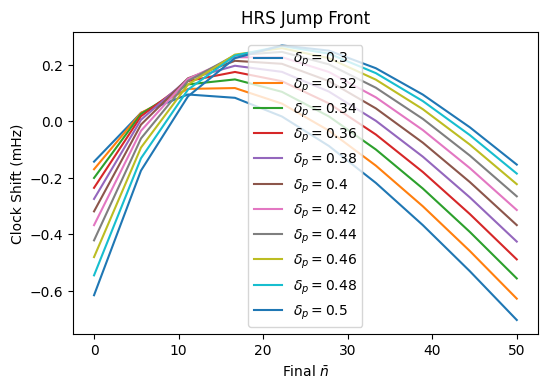

In [50]:
plt.figure(figsize=(6,4), dpi=100)

for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 3) ))
    maxshift = np.max(np.abs(1e3*results[ii,:]/(2.0*np.pi)))
    print(r'$\delta_p = $' + str(round(delPrimes[ii]/(2.0*np.pi), 3) ) + ", max shift = "+ str(maxshift))
plt.legend()
plt.title("HRS Jump Front")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

In [41]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-0.36,-0.34, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 30, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJump, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.000303844772575236
[-1.9996961552274248, 2.000303844772575]
0.0009055588641334043
[-1.9990944411358667, 2.0009055588641336]
0.0012325548217676635
[-1.9987674451782322, 2.0012325548217675]
0.0013339738784858162
[-1.9986660261215141, 2.0013339738784857]
0.0012505717366097266
[-1.9987494282633902, 2.00125057173661]
0.0010159098241836787
[-1.9989840901758162, 2.0010159098241838]
0.0006579172424946312
[-1.9993420827575055, 2.0006579172424948]
0.00019995046478348243
[-1.9998000495352166, 2.0001999504647836]
-0.00033865907819234143
[-2.000338659078192, 1.9996613409218076]
-0.0009421953387960967
[-2.000942195338796, 1.999057804661204]
0.00029699673142808596
[-1.9997030032685719, 2.000296996731428]
0.0008892021833064395
[-1.9991107978166935, 2.0008892021833065]
0.00120824950399005
[-1.99879175049601, 2.00120824950399]
0.0013030112156764656
[-1.9986969887843236, 2.0013030112156764]
0.001214016607013289
[-1.9987859833929866, 2.001214016607013]
0.0009746381111190753
[-1.999025361888881, 2.000974

$\delta_p = $-0.36, max shift = 0.21230853671648497
$\delta_p = $-0.358, max shift = 0.20738067587908923
$\delta_p = $-0.356, max shift = 0.20246472541002813
$\delta_p = $-0.354, max shift = 0.19756061995380347
$\delta_p = $-0.352, max shift = 0.19266829413895142
$\delta_p = $-0.35, max shift = 0.1929384205576144
$\delta_p = $-0.348, max shift = 0.2014908855464097
$\delta_p = $-0.346, max shift = 0.21002880391281
$\delta_p = $-0.344, max shift = 0.2185522571558059
$\delta_p = $-0.342, max shift = 0.22706132680082777
$\delta_p = $-0.34, max shift = 0.23555609439386951


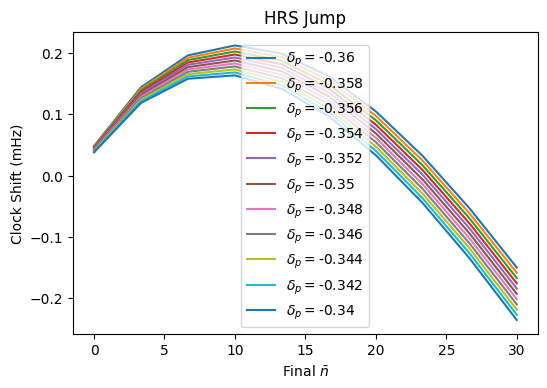

In [42]:
plt.figure(figsize=(6,4), dpi=100)

for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 3) ))
    maxshift = np.max(np.abs(1e3*results[ii,:]/(2.0*np.pi)))
    print(r'$\delta_p = $' + str(round(delPrimes[ii]/(2.0*np.pi), 3) ) + ", max shift = "+ str(maxshift))
plt.legend()
plt.title("HRS Jump")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

In [32]:
delPrimes/(2.*np.pi)

array([-0.4 , -0.39, -0.38, -0.37, -0.36, -0.35, -0.34, -0.33, -0.32,
       -0.31, -0.3 ])

In [27]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-0.5,-0.3, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 30, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJump, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.0009494473956943246
[-1.9990505526043056, 2.000949447395694]
0.0022325924843710552
[-1.9977674075156289, 2.002232592484371]
0.003130804859348902
[-1.9968691951406512, 2.003130804859349]
0.0037116921820127794
[-1.9962883078179872, 2.0037116921820126]
0.004031751574766198
[-1.995968248425234, 2.0040317515747663]
0.004137813586272684
[-1.9958621864137274, 2.0041378135862726]
0.004069067199162682
[-1.9959309328008372, 2.0040690671991626]
0.003858426558605766
[-1.9961415734413943, 2.003858426558606]
0.003533216180612741
[-1.9964667838193872, 2.0035332161806125]
0.0031156952176651107
[-1.9968843047823348, 2.003115695217665]
0.0008351790384713818
[-1.9991648209615287, 2.0008351790384715]
0.002018881873574978
[-1.997981118126425, 2.002018881873575]
0.002833532269872302
[-1.9971664677301277, 2.0028335322698725]
0.0033441451058383452
[-1.9966558548941618, 2.0033441451058382]
0.003604982758403426
[-1.9963950172415965, 2.0036049827584033]
0.003660905940777734
[-1.9963390940592223, 2.003660905940

$\delta_p = $-0.5, max shift = 0.6585534858481005
$\delta_p = $-0.48, max shift = 0.5826512766692619
$\delta_p = $-0.46, max shift = 0.5085341704521338
$\delta_p = $-0.44, max shift = 0.44286670190645727
$\delta_p = $-0.42, max shift = 0.3797691226240513
$\delta_p = $-0.4, max shift = 0.31817961411786194
$\delta_p = $-0.38, max shift = 0.2622565812736543
$\delta_p = $-0.36, max shift = 0.21230853671648497
$\delta_p = $-0.34, max shift = 0.2355560943938665
$\delta_p = $-0.32, max shift = 0.3197351151440887
$\delta_p = $-0.3, max shift = 0.40257380845079205


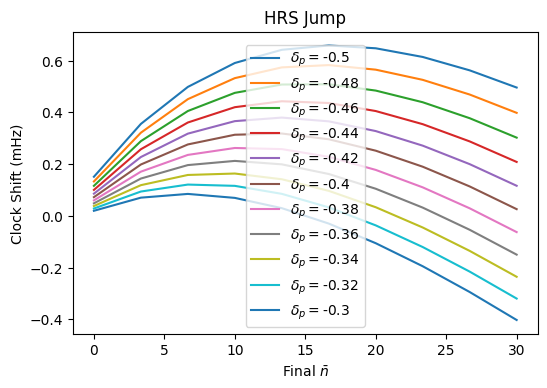

In [28]:
plt.figure(figsize=(6,4), dpi=100)

for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 3) ))
    maxshift = np.max(np.abs(1e3*results[ii,:]/(2.0*np.pi)))
    print(r'$\delta_p = $' + str(round(delPrimes[ii]/(2.0*np.pi), 3) ) + ", max shift = "+ str(maxshift))
plt.legend()
plt.title("HRS Jump")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

In [29]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-0.37,-0.35, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 30, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJump, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.00033898308282987816
[-1.99966101691717, 2.00033898308283]
0.000988326030370755
[-1.9990116739696293, 2.0009883260303707]
0.0013551453899925572
[-1.9986448546100075, 2.0013551453899927]
0.001489924083147488
[-1.9985100759168526, 2.0014899240831476]
0.0014346228698822318
[-1.9985653771301177, 2.001434622869882]
0.001223527615589155
[-1.9987764723844108, 2.001223527615589]
0.0008855842026068776
[-1.999114415797393, 2.000885584202607]
0.00044474732125536796
[-1.9995552526787446, 2.0004447473212554]
-7.909206273771682e-05
[-2.000079092062738, 1.9999209079372622]
-0.000669761128447511
[-2.0006697611284476, 1.9993302388715526]
0.00033183458846802326
[-1.999668165411532, 2.000331834588468]
0.0009716402419502571
[-1.9990283597580498, 2.0009716402419504]
0.0013304841306541776
[-1.9986695158693457, 2.001330484130654]
0.0014585810892511707
[-1.9985414189107489, 2.0014585810892513]
0.0013976224319228797
[-1.998602377568077, 2.0013976224319228]
0.0011818346502864732
[-1.9988181653497135, 2.001181

$\delta_p = $-0.37, max shift = 0.23712878266458276
$\delta_p = $-0.368, max shift = 0.2321403902546848
$\delta_p = $-0.366, max shift = 0.22716423473341446
$\delta_p = $-0.364, max shift = 0.222200250830729
$\delta_p = $-0.362, max shift = 0.2172483732600282
$\delta_p = $-0.36, max shift = 0.21230853671648497
$\delta_p = $-0.358, max shift = 0.20738067587908923
$\delta_p = $-0.356, max shift = 0.20246472541002813
$\delta_p = $-0.354, max shift = 0.19756061995380347
$\delta_p = $-0.352, max shift = 0.19266829413895142
$\delta_p = $-0.35, max shift = 0.1929384205576144


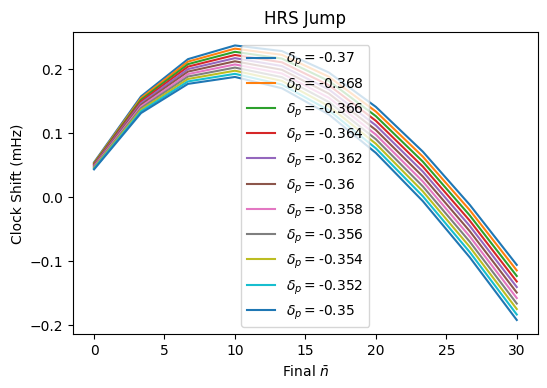

In [30]:
plt.figure(figsize=(6,4), dpi=100)

for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 3) ))
    maxshift = np.max(np.abs(1e3*results[ii,:]/(2.0*np.pi)))
    print(r'$\delta_p = $' + str(round(delPrimes[ii]/(2.0*np.pi), 3) ) + ", max shift = "+ str(maxshift))
plt.legend()
plt.title("HRS Jump")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

# Testing very sensitive sequences for measuring heating rate:

In [86]:
def shiftCurveNonOptimal(func, t1, T, t2, delp1, delp2, Omega0, nbarfs, Ncut):
    psi0 = psi(1.+0.j,0.+0.j)
    x0 = -5.0
    x1 = 5.0
    guessTol = 5.0
    tol = 1e-6
    pts = np.size(nbarfs)
    shifts = np.zeros(pts)
    print(delp1)
    for ii in range(pts):
        shifts[ii] = root(func, args=(psi0, t1, T, t2, delp1, delp2, Omega0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
        print(shifts[ii])
        x0 = shifts[ii] - guessTol
        x1 = shifts[ii] + guessTol
        print([x0,x1])
    return shifts

In [64]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurveNonOptimal(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.532126466110803
[-2.467873533889197, 3.532126466110803]
0.5235993288709556
[-2.4764006711290443, 3.5235993288709557]
0.5169289487811158
[-2.483071051218884, 3.516928948781116]
0.511582261348999
[-2.488417738651001, 3.511582261348999]
0.5071750883344732
[-2.4928249116655268, 3.5071750883344732]
0.503426908012849
[-2.496573091987151, 3.503426908012849]
0.5001378874584099
[-2.49986211254159, 3.50013788745841]
0.4971714879067844
[-2.5028285120932154, 3.4971714879067846]
0.4944368782876825
[-2.5055631217123175, 3.4944368782876825]
0.49187404506277654
[-2.5081259549372232, 3.4918740450627768]
0.4256896045700355
[-2.5743103954299644, 3.4256896045700356]
0.4185677311465926
[-2.5814322688534075, 3.4185677311465925]
0.41293149535079654
[-2.5870685046492037, 3.4129314953507963]
0.4083544031713308
[-2.5916455968286694, 3.4083544031713306]
0.40452906215608575
[-2.5954709378439142, 3.4045290621560858]
0.4012310117504236
[-2.5987689882495766, 3.4012310117504234]
0.3983003452779725
[-2.6016996547220

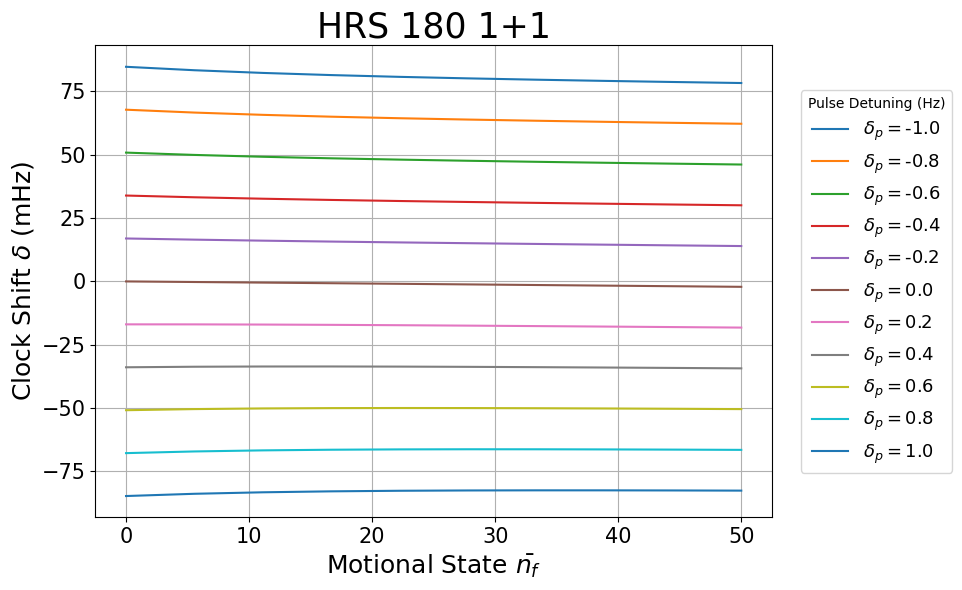

In [65]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 180 1+1",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.set_cmap("viridis") 
plt.show()

In [87]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 60, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurveNonOptimal(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

-6.283185307179586
-0.0025085559271617137
[-5.002508555927162, 4.997491444072838]
-0.1439678441783562
[-5.1439678441783565, 4.8560321558216435]
-0.35879254950910333
[-5.358792549509103, 4.641207450490897]
-0.6562963838558458
[-5.656296383855846, 4.343703616144154]
-1.0556241296914253
[-6.0556241296914255, 3.9443758703085745]
-1.5908859487791935
[-6.590885948779194, 3.4091140512208065]
-2.3063165649350745
[-7.3063165649350745, 2.6936834350649255]
-3.2215563167101164
[-8.221556316710117, 1.7784436832898836]
-4.262512973568652
[-9.262512973568652, 0.7374870264313476]
-5.256613134044771
[-10.25661313404477, -0.2566131340447706]
-5.026548245743669
-0.0036301692877437537
[-5.003630169287744, 4.996369830712256]
-0.11867077035981749
[-5.1186707703598175, 4.8813292296401825]
-0.2946174406721514
[-5.294617440672152, 4.705382559327848]
-0.5418837442712957
[-5.541883744271296, 4.458116255728704]
-0.8826634401590552
[-5.882663440159055, 4.117336559840945]
-1.3607030657781285
[-6.360703065778129, 3.

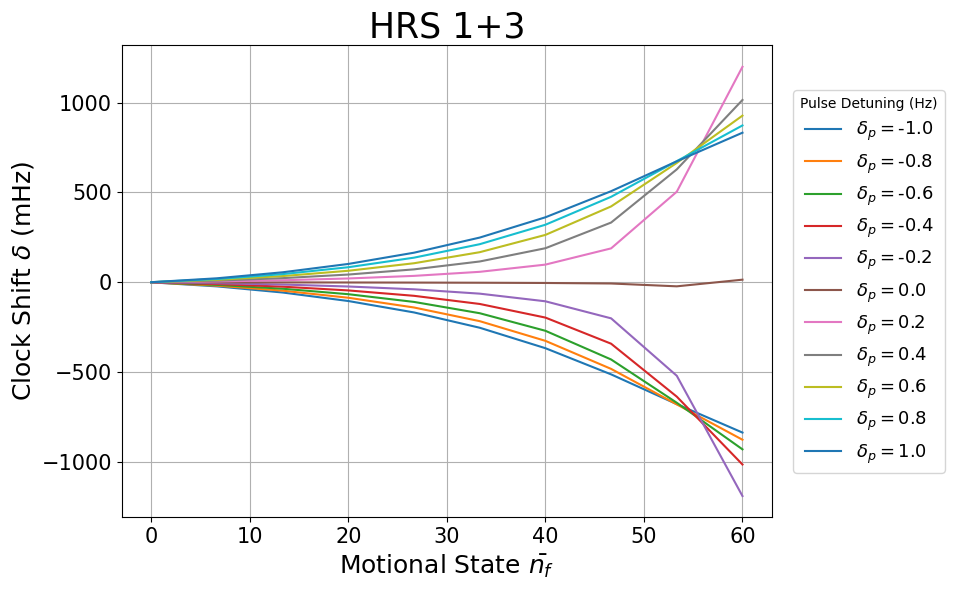

In [88]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 1+3",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.set_cmap("viridis") 
plt.show()
#used x0 = -5.0, x1 = 5.0, guessTol = 5.0

In [22]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 5.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurveNonOptimal(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

-6.283185307179586
0.5291876327379628
[-4.470812367262037, 5.529187632737963]
0.4744235243987995
[-4.5255764756012, 5.4744235243988]
0.5231224745944479
[-4.476877525405552, 5.523122474594448]
0.736047198096142
[-4.263952801903858, 5.736047198096142]
1.1765408769424166
[-3.8234591230575834, 6.176540876942417]
1.8213880078826428
[-3.1786119921173572, 6.821388007882643]
2.488539754141024
[-2.511460245858976, 7.488539754141025]
2.9812703218894967
[-2.0187296781105033, 7.981270321889497]
3.2581551660417163
[-1.7418448339582837, 8.258155166041716]
3.3765058248951654
[-1.6234941751048346, 8.376505824895165]
-5.026548245743669
0.4218178971239519
[-4.578182102876048, 5.421817897123952]
0.3781504788602771
[-4.621849521139723, 5.378150478860277]
0.41854982117755546
[-4.581450178822444, 5.418549821177556]
0.5947541524616634
[-4.405245847538336, 5.594754152461664]
0.9638703412958411
[-4.036129658704159, 5.963870341295841]
1.5188227779630454
[-3.481177222036955, 6.518822777963045]
2.117548588422431


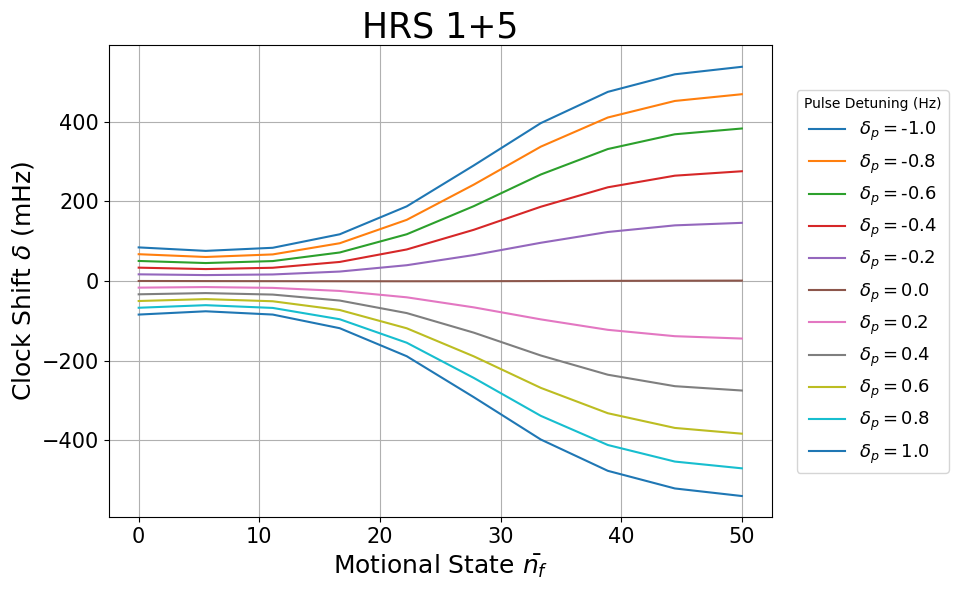

In [23]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 1+5",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.set_cmap("viridis") 
plt.show()

In [26]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 7.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurveNonOptimal(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

-6.283185307179586
-0.0055130658157432465
[-5.005513065815744, 4.994486934184256]
-0.2991581121207642
[-5.2991581121207645, 4.7008418878792355]
-0.7964636414526872
[-5.7964636414526876, 4.2035363585473124]
-1.4953755172688374
[-6.495375517268838, 3.5046244827311623]
-2.3103036754951902
[-7.31030367549519, 2.6896963245048098]
-3.0941778538849998
[-8.094177853885, 1.9058221461150002]
-3.7576003073381274
[-8.757600307338127, 1.2423996926618726]
-4.285783076891408
[-9.28578307689141, 0.7142169231085918]
-4.69565265197307
[-9.69565265197307, 0.30434734802692986]
-5.010420769749046
[-10.010420769749047, -0.01042076974904571]
-5.026548245743669
-0.007646626096129047
[-5.007646626096129, 4.992353373903871]
-0.24857453119816425
[-5.248574531198164, 4.751425468801836]
-0.6663752038588014
[-5.666375203858801, 4.333624796141199]
-1.2840727114521329
[-6.284072711452133, 3.715927288547867]
-2.0688648395903204
[-7.06886483959032, 2.9311351604096796]
-2.907564245181871
[-7.907564245181871, 2.092435754

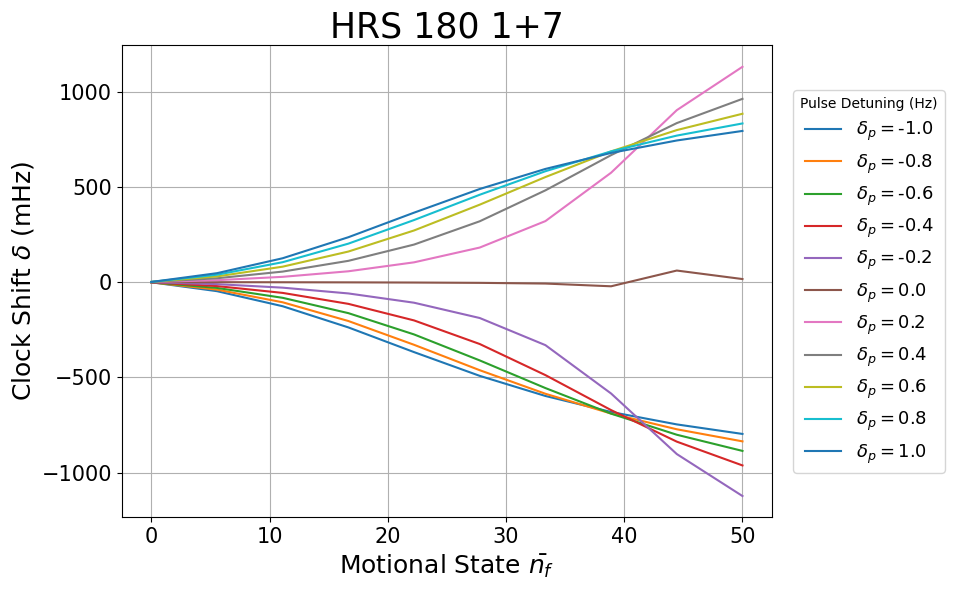

In [27]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 180 1+7",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.set_cmap("viridis") 
plt.show()

In [24]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 9.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurveNonOptimal(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

-6.283185307179586
0.5262805715763602
[-4.47371942842364, 5.52628057157636]
0.5052173530627233
[-4.494782646937277, 5.505217353062723]
0.8586275799322048
[-4.141372420067795, 5.858627579932205]
1.6456823862378025
[-3.3543176137621975, 6.6456823862378025]
2.7065103262027836
[-2.2934896737972164, 7.706510326202784]
3.6260523919829573
[-1.3739476080170427, 8.626052391982958]
4.204189789537854
[-0.7958102104621458, 9.204189789537853]
4.526170564233689
[-0.4738294357663113, 9.526170564233688]
4.707783234151567
[-0.29221676584843337, 9.707783234151567]
4.819412745891482
[-0.18058725410851828, 9.819412745891482]
-5.026548245743669
0.41801470828190995
[-4.58198529171809, 5.41801470828191]
0.40339154401201593
[-4.596608455987984, 5.403391544012016]
0.6995189722960501
[-4.30048102770395, 5.69951897229605]
1.3846401043107728
[-3.6153598956892274, 6.384640104310773]
2.3806867218340475
[-2.6193132781659525, 7.3806867218340475]
3.312970412067939
[-1.6870295879320611, 8.312970412067939]
3.91487403552

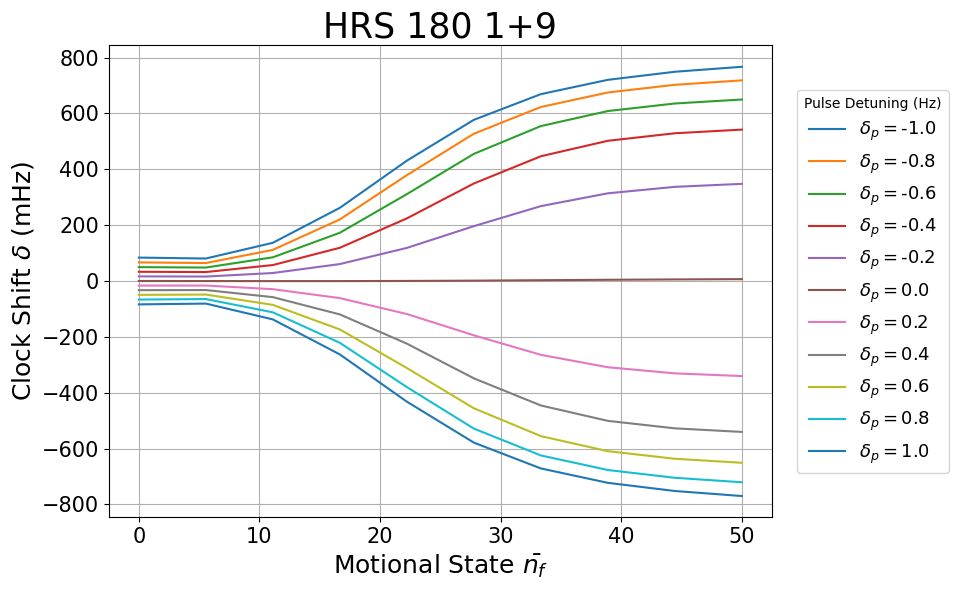

In [25]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 180 1+9",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.set_cmap("viridis") 
plt.show()

# Inspecting the bump in curve for no detuning at high final nbar

In [162]:
def shiftCurveNonOptimal1(func, t1, T, t2, delp1, delp2, Omega0, nbarfs, Ncut):
    psi0 = psi(1.+0.j,0.+0.j)
    x0 = -5.0
    x1 = 5.0
    guessTol = 1.0
    tol = 1e-6
    pts = np.size(nbarfs)
    shifts = np.zeros(pts)
    print(delp1)
    for ii in range(pts):
        shifts[ii] = root(func, args=(psi0, t1, T, t2, delp1, delp2, Omega0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
        print(shifts[ii])
        if ii>0:
            step = shifts[ii]-shifts[ii-1]
            if step>0:
                x0 = shifts[ii] - guessTol
                x1 = shifts[ii] + step**2 +guessTol
            if step<0:
                x0 = shifts[ii] - step**2 -guessTol
                x1 = shifts[ii] + guessTol
        else: 
            x0 = 1.0
            x1 = -1.0
        print([x0,x1])
    return shifts

def shiftCurveNonOptimal2(func, t1, T, t2, delp1, delp2, Omega0, nbarfs, Ncut):
    psi0 = psi(1.+0.j,0.+0.j)
    x0 = -1.0
    x1 = 0.0
    guessTol = 1.0
    tol = 1e-6
    pts = np.size(nbarfs)
    shifts = np.zeros(pts)
    print(delp1)
    for ii in range(pts):
        shifts[ii] = root(func, args=(psi0, t1, T, t2, delp1, delp2, Omega0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
        print(shifts[ii])
        x0 = shifts[ii] - guessTol
        x1 = shifts[ii] + guessTol
        print([x0,x1])
    return shifts

def shiftCurveNonOptimal3(func, t1, T, t2, delp1, delp2, Omega0, nbarfs, Ncut):
    psi0 = psi(1.+0.j,0.+0.j)
    x0 = -11.0
    x1 = -9.0
    guessTol = 1.0
    tol = 1e-6
    pts = np.size(nbarfs)
    shifts = np.zeros(pts)
    print(delp1)
    for ii in range(pts):
        shifts[ii] = root(func, args=(psi0, t1, T, t2, delp1, delp2, Omega0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
        print(shifts[ii])
        x0 = shifts[ii] - guessTol
        x1 = shifts[ii] + guessTol
        print([x0,x1])
    return shifts

In [186]:
delPts = 1
delPrimes = 2.0*np.pi*np.linspace(0,1, delPts)
nbarfPts = 200
nbarfs1 = np.linspace(0, 55, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurveNonOptimal(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs1, Ncut)

0.0
-0.00029040901387208533
[-5.000290409013872, 4.999709590986128]
-0.0003777978057522751
[-5.000377797805752, 4.999622202194248]
-0.0004654230172360058
[-5.000465423017236, 4.999534576982764]
-0.0005532943252857707
[-5.000553294325286, 4.999446705674714]
-0.000641421431030745
[-5.00064142143103, 4.99935857856897]
-0.000729814061161516
[-5.000729814061161, 4.999270185938839]
-0.0008184819697472784
[-5.000818481969747, 4.999181518030253]
-0.000907434940503164
[-5.000907434940503, 4.999092565059497]
-0.0009966827894678709
[-5.000996682789468, 4.999003317210532]
-0.0010862353680325782
[-5.0010862353680325, 4.9989137646319675]
-0.001176102566294989
[-5.001176102566295, 4.998823897433705]
-0.0012662943166927992
[-5.001266294316693, 4.998733705683307]
-0.001356820597885969
[-5.001356820597886, 4.998643179402114]
-0.001447691438850632
[-5.001447691438851, 4.998552308561149]
-0.0015389169231467457
[-5.001538916923146, 4.998461083076854]
-0.001630507193358261
[-5.001630507193358, 4.99836949280

-0.020383257364175286
[-5.020383257364175, 4.979616742635825]
-0.020724215153128358
[-5.020724215153129, 4.979275784846871]
-0.0210735514917376
[-5.021073551491738, 4.978926448508262]
-0.021431640976541752
[-5.021431640976542, 4.978568359023458]
-0.02179888100133028
[-5.02179888100133, 4.97820111899867]
-0.022175693513382815
[-5.0221756935133826, 4.9778243064866174]
-0.022562526934607568
[-5.022562526934608, 4.977437473065392]
-0.02295985826601928
[-5.022959858266019, 4.977040141733981]
-0.023368195396303353
[-5.023368195396303, 4.976631804603697]
-0.02378807963772612
[-5.023788079637726, 4.976211920362274]
-0.02422008851631683
[-5.024220088516317, 4.975779911483683]
-0.024664838846289984
[-5.02466483884629, 4.97533516115371]
-0.025122990123162405
[-5.025122990123163, 4.974877009876837]
-0.025595248274795195
[-5.025595248274795, 4.974404751725205]
-0.026082369815173426
[-5.026082369815174, 4.973917630184826]
-0.02658516645243959
[-5.026585166452439, 4.973414833547561]
-0.02710451020985

In [163]:
delPts = 1
delPrimes = 2.0*np.pi*np.linspace(0,1, delPts)
nbarfPts = 200
nbarfs2 = np.linspace(55, 60, nbarfPts)
results2 = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results2[ii,:] = shiftCurveNonOptimal2(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs2, Ncut)

0.0
-0.3561192732938481
[-1.356119273293848, 0.6438807267061519]
-0.3645104203552637
[-1.3645104203552636, 0.6354895796447363]
-0.37330978901589845
[-1.3733097890158985, 0.6266902109841015]
-0.3825477987927468
[-1.3825477987927468, 0.6174522012072532]
-0.3922579543105344
[-1.3922579543105345, 0.6077420456894655]
-0.402477244609571
[-1.402477244609571, 0.597522755390429]
-0.4132466057793654
[-1.4132466057793653, 0.5867533942206347]
-0.42461145888832075
[-1.4246114588883207, 0.5753885411116793]
-0.43662233781207715
[-1.4366223378120773, 0.5633776621879228]
-0.4493356248685427
[-1.4493356248685427, 0.5506643751314573]
-0.4628144163484791
[-1.462814416348479, 0.5371855836515209]
-0.4771295452878332
[-1.4771295452878332, 0.5228704547121668]
-0.49236079559328266
[-1.4923607955932827, 0.5076392044067173]
-0.5085983502420013
[-1.5085983502420013, 0.4914016497579987]
-0.5259445274567929
[-1.5259445274567929, 0.4740554725432071]
-0.5445158732513561
[-1.5445158732513562, 0.4554841267486439]
-0.56

-10.312970901663563
[-11.312970901663563, -9.312970901663563]
-10.314751246187061
[-11.314751246187061, -9.314751246187061]
-10.316493668830372
[-11.316493668830372, -9.316493668830372]
-10.31819937097311
[-11.31819937097311, -9.31819937097311]
-10.319869503815845
[-11.319869503815845, -9.319869503815845]
-10.321505170970987
[-11.321505170970987, -9.321505170970987]
-10.323107430894307
[-11.323107430894307, -9.323107430894307]
-10.324677299169478
[-11.324677299169478, -9.324677299169478]
-10.326215750656885
[-11.326215750656885, -9.326215750656885]
-10.3277237215114
[-11.3277237215114, -9.3277237215114]
-10.329202111084259
[-11.329202111084259, -9.329202111084259]
-10.330651783712517
[-11.330651783712517, -9.330651783712517]
-10.332073570405596
[-11.332073570405596, -9.332073570405596]
-10.333468270435349
[-11.333468270435349, -9.333468270435349]
-10.334836652835657
[-11.334836652835657, -9.334836652835657]
-10.336179457818647
[-11.336179457818647, -9.336179457818647]
-10.3374973981113

In [182]:
delPts = 1
delPrimes = 2.0*np.pi*np.linspace(0,1, delPts)
nbarfPts = 200
nbarfs3 = np.linspace(59, 200, nbarfPts)
results3 = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results3[ii,:] = shiftCurveNonOptimal3(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs3, Ncut)

0.0
-10.348567617052131
[-11.348567617052131, -9.348567617052131]
-10.373783709016006
[-11.373783709016006, -9.373783709016006]
-10.390833337547374
[-11.390833337547374, -9.390833337547374]
-10.403147185202696
[-11.403147185202696, -9.403147185202696]
-10.412470557160601
[-11.412470557160601, -9.412470557160601]
-10.419785040783903
[-11.419785040783903, -9.419785040783903]
-10.425685020151565
[-11.425685020151565, -9.425685020151565]
-10.430551449364016
[-11.430551449364016, -9.430551449364016]
-10.434639753579841
[-11.434639753579841, -9.434639753579841]
-10.438127595680141
[-11.438127595680141, -9.438127595680141]
-10.44114237479071
[-11.44114237479071, -9.44114237479071]
-10.443777827057064
[-11.443777827057064, -9.443777827057064]
-10.446104454946157
[-11.446104454946157, -9.446104454946157]
-10.448176305507848
[-11.448176305507848, -9.448176305507848]
-10.450035506515283
[-11.450035506515283, -9.450035506515283]
-10.451715380514182
[-11.451715380514182, -9.451715380514182]
-10.453

-10.492680907244198
[-11.492680907244198, -9.492680907244198]
-10.492842970359412
[-11.492842970359412, -9.492842970359412]
-10.49300454137988
[-11.49300454137988, -9.49300454137988]
-10.493165626798632
[-11.493165626798632, -9.493165626798632]
-10.493326232879607
[-11.493326232879607, -9.493326232879607]
-10.493486365665719
[-11.493486365665719, -9.493486365665719]
-10.493646030986602
[-11.493646030986602, -9.493646030986602]
-10.493805234466041
[-11.493805234466041, -9.493805234466041]
-10.49396398152908
[-11.49396398152908, -9.49396398152908]
-10.494122277408948
[-11.494122277408948, -9.494122277408948]
-10.494280127153635
[-11.494280127153635, -9.494280127153635]
-10.49443753563226
[-11.49443753563226, -9.49443753563226]
-10.494594507541192
[-11.494594507541192, -9.494594507541192]
-10.494751047409935
[-11.494751047409935, -9.494751047409935]
-10.494907159606845
[-11.494907159606845, -9.494907159606845]
-10.49506284834456
[-11.49506284834456, -9.49506284834456]
-10.495218117685273


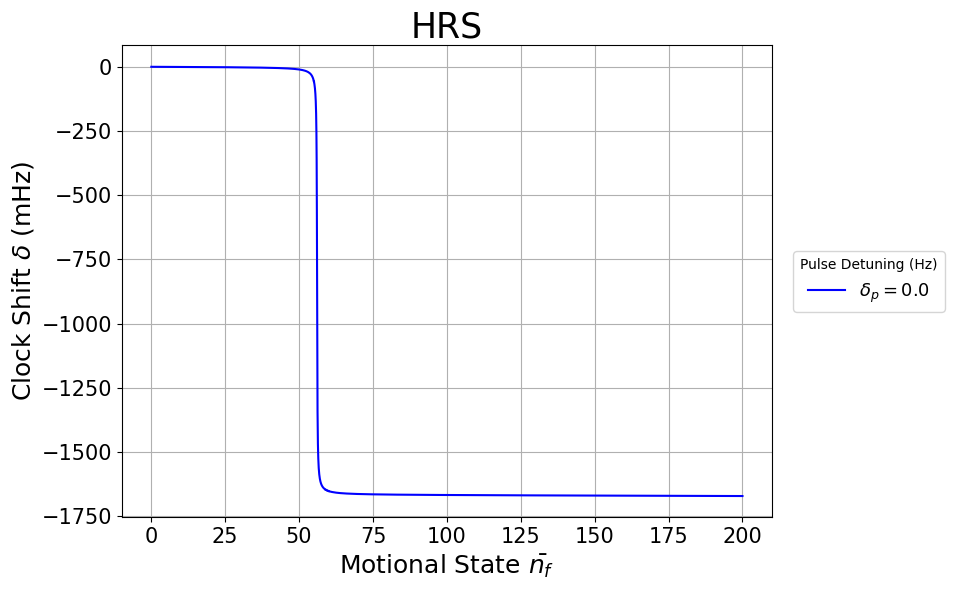

In [188]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs1, 1e3*results[ii,:]/(2.0*np.pi), c='b', label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
    plt.plot(nbarfs2, 1e3*results2[ii,:]/(2.0*np.pi), c='b')#, color=cm(1+np.abs(ii-delPts//2)))
    plt.plot(nbarfs3, 1e3*results3[ii,:]/(2.0*np.pi), c='b')#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.set_cmap("viridis") 
#plt.xlim([0,58])
#plt.ylim([-100,0])
plt.show()